In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from lion_pytorch import Lion
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utilities.utils import *

from src.plotting import Plotter
from src.gl_solver import GLSolver
from src.parameters_init import ParametersInit
from src.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1
# SEED = 1234

# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

ModuleNotFoundError: No module named 'lion_pytorch'

In [5]:
random_input_field: RandomInputField = RandomInputField(
    Nx=4,
    Ny=4,
    input_to_defect_ratio=4*4,
    mean=5.4,
    std_deviation=0.8,
    time_period = 25
)

NameError: name 'RandomInputField' is not defined

In [ ]:
parameters: ParametersInit = ParametersInit(
    Lx=30,
    Ly=30,
    Nx=random_input_field.Nx,
    Ny=random_input_field.Ny,
    dt=0.005,
    T_End=1,
    parallel_runs=1,
    input_scale=0.75,
    mem_coef=1
)

gl_solver: GLSolver = GLSolver(
    parameters=parameters,
    random_input_field=random_input_field,
    input_myu=None
)

In [ ]:
# Record the whole A (1000, 4, 4)
A_norm = gl_solver.run_computation(
    time_period_parameter=28,
    _mean=5.4,
    std_deviation=1
)

100%|██████████| 200/200 [00:00<00:00, 3771.97it/s]


In [ ]:
print("Unique Myus count\t", np.count_nonzero(np.unique(parameters.myu_in[:, :, :])))

unique_values, counts = np.unique(parameters.myu_in, return_counts=True)

print("Max value of myu:\t", np.max(parameters.myu_in[:, :, :]))
print("Min value of myu:\t", np.min(parameters.myu_in[:, :, :]))
print("Unique values:", (unique_values.tolist()))
print("Counts:\t\t", counts)

print(f"A.shape={parameters.A_original[:, :, :].shape},\nMyu.shape={parameters.myu_in[:, :, :].shape},\n")

print("Any NaN values in Myu\t\t", np.isnan(parameters.myu_in).any())
print("Any NaN values in A_original\t", np.isnan(parameters.A_original).any())

Unique Myus count	 8
Max value of myu:	 85.90245224253178
Min value of myu:	 43.226072956063064
Unique values: [43.226072956063064, 46.302590316465334, 50.7812361918458, 56.77719825551743, 70.8010179956641, 84.74652345841083, 84.96546965753905, 85.90245224253178]
Counts:		 [448 448 448  64 448 448 448 448]
A.shape=(1, 200, 4, 4),
Myu.shape=(1, 200, 4, 4),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


In [ ]:
plotter = Plotter(data=A_norm)

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

100%|██████████| 200/200 [00:07<00:00, 27.89it/s]


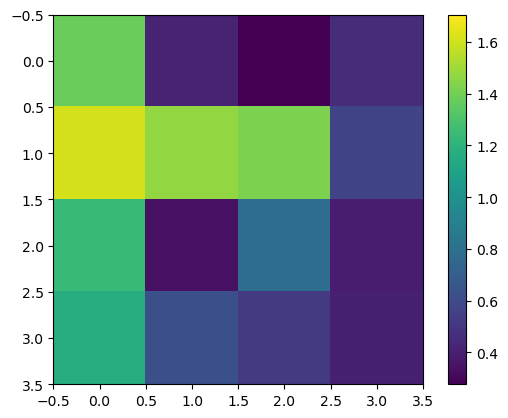

In [ ]:
plotter.output_plot(gl_solver.get_paramters().mem_rat)

In [ ]:
# plotter.output_animation(gl_solver.get_paramters().mem_rat, save_gif=True, file_name=r"a_norm.gif")

In [ ]:
# plotter = Plotter(data=parameters.myu_in[:, :, :].squeeze(0))

In [ ]:
# plotter.output_animation(gl_solver.get_paramters().mem_rat, save_gif=True, file_name=r"myu_anim.gif")

In [ ]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, layers):
        super(SimpleNeuralNetwork, self).__init__()

        self._depth = len(layers) - 1
        self._activation_function = torch.nn.Tanh
        layers_list = list()

        for i in range(self._depth - 1):
            layers_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1], dtype=torch.complex64)))
            layers_list.append(('activation_%d' % i, self._activation_function()))

        layers_list.append(('layer_%d' % (self._depth - 1), torch.nn.Linear(layers[-2], layers[-1], dtype=torch.complex64)))
        layerDict = OrderedDict(layers_list)
        self._layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self._layers(x)
        return out

In [ ]:
class PINN:
    def __init__(self, X, u, layers, lb, ub, lambda_reg=None, optimizer=Lion, myu_bound=1, clipping=False):
        # boundary conditions
        self.lb = torch.tensor(lb, dtype=torch.int64).to(device)
        self.ub = torch.tensor(ub, dtype=torch.int64).to(device)

        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        self.y = torch.tensor(X[:, 1:2], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        self.t = torch.tensor(X[:, 2:3], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        self.u = torch.tensor(u, requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)


        # Create a tensor with random values
        myu_tensor = torch.randn(2, 4, dtype=torch.float64, requires_grad=True).to(device)
        transformed_myu_tensor = transform_and_stack(myu_tensor, 4, 25)
        self.dnn = SimpleNeuralNetwork(layers).to(device)
        self.dnn.myu = nn.Parameter(transformed_myu_tensor).to(device)

        params_list = list(self.dnn.parameters())

        self.optimizer = ComplexOptimizer(
            optimizer_type=optimizer, # Lion, LBFGS
            params=params_list,
            lr=0.5
        )

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr=0.5)
        self.optimizer_counter = 0

        self.history = {
            'u_loss': [],
            'f_loss': [],
            'total_loss': [],
            'myu': []
        }

        self.lambda_reg = lambda_reg
        self.myu_bound = myu_bound

        self.initial_f_loss = None
        self.initial_u_loss = None

        self.clipping = clipping

        # print("u", self.u.shape)
        # print("x", self.x.shape)
        # print("y", self.y.shape)
        # print("t", self.t.shape)

    def net_u(self, x, y, t):
        u = self.dnn(torch.cat([x, y, t], dim=1).view(-1, 3))
        return u

    def clip(self, x, lower_bound, upper_bound):
        return torch.clamp(x, min=lower_bound, max=upper_bound)

    def update_myu(self):
        with torch.no_grad():
            self.myu.data = self.clip(self.myu, 0.0, self.myu_bound)

    def net_f(self, x, y, t):
        torch.autograd.set_detect_anomaly(True)
        u = self.net_u(x, y, t).view(200, 4, 4)

        # myu = self.myu

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_y = torch.autograd.grad(
            u, y,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True
        )[0]
        u_yy = torch.autograd.grad(
            u_y, y,
            grad_outputs=torch.ones_like(u_y),
            create_graph=True
        )[0]

        # print("u", u.shape)
        # print("u_t", u_t.shape)
        # print("u_x", u_x.shape)
        # print("u_y", u_y.shape)
        # print("u_xx", u_xx.shape)
        # print("u_yy", u_yy.shape)
        # print("torch.pow(torch.abs(u), 2)*u", (torch.pow(torch.abs(u), 2)*u).shape)

        f = u_t - self.dnn.myu.data*u - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u

        u_x_lb = u_x[self.lb]
        u_x_ub = u_x[self.ub]

        u_y_lb = u_y[self.lb]
        u_y_ub = u_y[self.ub]

        # print(u_x_lb.shape)

        # u_x_lb_correct = torch.zeros_like(self.lb)
        # u_x_ub_correct = torch.zeros_like(self.ub)
        # u_y_lb_correct = torch.zeros_like(self.lb)
        # u_y_ub_correct = torch.zeros_like(self.ub)

        u_x_lb_correct = self.lb[0] # if the first coordinate of lb is x
        u_x_ub_correct = self.ub[0] # if the first coordinate of ub is x
        u_y_lb_correct = self.lb[1] # if the second coordinate of lb is y
        u_y_ub_correct = self.ub[1] # if the second coordinate of ub is y

        # print(u_x_lb_correct.shape)

        boundary_error_x_lb = ((u_x_lb - u_x_lb_correct)**2).mean()
        boundary_error_x_ub = ((u_x_ub - u_x_ub_correct)**2).mean()

        boundary_error_y_lb = ((u_y_lb - u_y_lb_correct)**2).mean()
        boundary_error_y_ub = ((u_y_ub - u_y_ub_correct)**2).mean()

        boundary_error = boundary_error_x_lb + boundary_error_x_ub + \
                        boundary_error_y_lb + boundary_error_y_ub

        # Under maintenance!
        # boundary_error_x_lb = ((u_x_lb - u_x_lb_correct)**2).mean()
        # boundary_error_x_ub = ((u_x_ub - u_x_ub_correct)**2).mean()

        # boundary_error_y_lb = ((u_y_lb - u_y_lb_correct)**2).mean()
        # boundary_error_y_ub = ((u_y_ub - u_y_ub_correct)**2).mean()

        # boundary_error = boundary_error_x_lb + boundary_error_x_ub + \
        #                  boundary_error_y_lb + boundary_error_y_ub

        # Add boundary error term to your f function
        f = f + boundary_error

        free_memory(u_t, u_x, u_y, u_xx, u_yy)
        return f

    def loss_func(self):

        u_pred = self.net_u(self.x, self.y, self.t).view(200, 4, 4)
        f_pred = self.net_f(self.x, self.y, self.t)

        u_loss = torch.mean(torch.abs((self.u - u_pred) ** 2))
        f_loss = torch.mean(torch.abs(f_pred) ** 2)

        if self.lambda_reg is not None:
            myu_reg = self.lambda_reg * torch.sum(self.myu)
            loss = u_loss + f_loss + myu_reg
        else:
            loss = u_loss + f_loss

        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)

        if self.clipping:
            self.update_myu()

        self.optimizer_counter += 1
        # if self.optimizer_counter % 10 == 0:
        #     print('Iter: %d, u_loss: %s, f_loss: %s, total loss: %s, myu:\n %s \n' %
        #             (
        #                 self.optimizer_counter,
        #                 u_loss.item(),
        #                 f_loss.item(),
        #                 loss.item(),
        #                 self.myu.cpu().detach().numpy()
        #             )
        #         )

        free_memory(u_loss, f_loss, u_pred, f_pred)
        return loss

    def train(self, epochs):
        self.dnn.train()

        self.history = {
            'u_loss': [],
            'f_loss': [],
            'total_loss': [],
            'myu': []
        }

        for epoch in tqdm(range(epochs)):

            u_pred = self.net_u(self.x, self.y, self.t).view(200, 4, 4)
            f_pred = self.net_f(self.x, self.y, self.t)

            # print("u shape", self.u.shape)
            # print("u pred shape", u_pred.shape)
            u_loss = torch.mean(torch.abs((self.u - u_pred) ** 2))
            f_loss = torch.mean(torch.abs(f_pred)**2)

            # store the initial losses
            if epoch == 0:
                self.initial_f_loss = f_loss.item()
                self.initial_u_loss = u_loss.item()

            # check early stopping conditions
            if (self.initial_f_loss / f_loss.item() >= 1000 and
                self.initial_u_loss - u_loss.item() >= 10):
                print('It: %d, u_loss: %s, f_loss: %s, total loss: %s myu max: %s' %
                       (
                        epoch,
                        u_loss.item(),
                        f_loss.item(),
                        loss.item(),
                        torch.max(self.dnn.myu.cpu().detach())
                    )
                )
                print("Early stopping condition reached.")
                break

            if self.lambda_reg is not None:
                myu_reg = self.lambda_reg * torch.sum(self.myu)
                loss = u_loss + f_loss + myu_reg
            else:
                loss = u_loss + f_loss

            self.history['u_loss'].append(u_loss.item())
            self.history['f_loss'].append(f_loss.item())
            self.history['total_loss'].append(loss.item())
            self.history['myu'].append(self.dnn.myu.cpu().detach().numpy())

            self.optimizer_Adam.zero_grad()
            loss.backward(retain_graph=True)
            self.optimizer_Adam.step()

            if self.clipping:
                self.update_myu()

            if epoch % 10 == 0:
                print('It: %d, u_loss: %s, f_loss: %s, total loss: %s myu max: %s' %
                       (
                        epoch,
                        u_loss.item(),
                        f_loss.item(),
                        loss.item(),
                        torch.max(self.dnn.myu.cpu().detach())
                    )
                )

            if epoch % 30 == 0:
                self.optimizer.step(self.loss_func)

            free_memory(u_loss, f_loss, u_pred)

    def predict(self, X):

        x = torch.tensor(X[:, 0:1], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        t = torch.tensor(X[:, 2:3], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)

        self.dnn.eval()

        u = self.net_u(x, y, t)
        f = self.net_f(x, y, t)

        u = u.view(parameters.mem_rat, parameters.Nx, parameters.Ny)

        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()

        return u, f

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [ ]:
class ComplexOptimizer(torch.optim.Optimizer):
    def __init__(self, optimizer_type, params, **kwargs):
        self.defaults = kwargs
        super(ComplexOptimizer, self).__init__(params, self.defaults)

        # Split complex parameters into real and imaginary parts
        real_params = []
        imag_params = []
        self.is_imag = []
        for param_group in self.param_groups:
            for param in param_group["params"]:
                if param.is_complex():
                    real_param = param.real.clone().detach().requires_grad_(True)
                    imag_param = param.imag.clone().detach().requires_grad_(True)
                    real_params.append(real_param)
                    imag_params.append(imag_param)
                    self.is_imag.append(True)
                else:
                    real_params.append(param)
                    self.is_imag.append(False)

        # Create two optimizers, one for real parts and one for imaginary parts
        self.real_optimizer = optimizer_type(real_params, **self.defaults)
        self.imag_optimizer = optimizer_type(imag_params, **self.defaults)

    @torch.no_grad()
    def step(self, closure):
        # Define a closure for real parts
        def real_closure():
            real_loss = closure()
            if real_loss is not None:
                real_loss.backward(retain_graph=True)
            return real_loss

        # Define a closure for imaginary parts
        def imag_closure():
            imag_loss = closure()
            if imag_loss is not None:
                imag_loss.backward()
            return imag_loss

        # Optimize real and imaginary parts separately
        with torch.enable_grad():
            real_loss = self.real_optimizer.step(real_closure)
            imag_loss = self.imag_optimizer.step(imag_closure)

        # Update the original complex parameters with the optimized real and imaginary parts
        for param_group, real_param_group, imag_param_group in zip(self.param_groups, self.real_optimizer.param_groups, self.imag_optimizer.param_groups):
            for param, real_param, imag_param in zip(compress(param_group["params"], self.is_imag), compress(real_param_group["params"],self.is_imag), imag_param_group["params"]):
                if param.is_complex():
                    with torch.no_grad():
                        param.copy_(torch.complex(real_param, imag_param))

        return real_loss + imag_loss

In [ ]:
f = SimpleNeuralNetwork([2,4,3]).to(device).parameters()

In [ ]:
def free_memory(*variables):
    del variables
    torch.cuda.empty_cache()

In [ ]:
class PINN:
    def __init__(self, X, u, layers, lb, ub, lambda_reg=None, optimizer=Lion, myu_bound=1, clipping=False):
        # boundary conditions
        self.lb = torch.tensor(lb, dtype=torch.int64).to(device)
        self.ub = torch.tensor(ub, dtype=torch.int64).to(device)

        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        self.y = torch.tensor(X[:, 1:2], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        self.t = torch.tensor(X[:, 2:3], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        self.u = torch.tensor(u, requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)

        # self.myu = torch.randn(2, 4, dtype=torch.float64, requires_grad=True)
        # # self.myu.data = transform_and_stack(self.myu.data, 10, 25).flatten().
        # # self.myu = torch.nn.Parameter(self.myu.to(device))
        # self.myu = transform_and_stack(self.myu.to(device), 4, 25)

        # # simple neural network
        # self.dnn = SimpleNeuralNetwork(layers).to(device)
        # self.dnn.register_parameter('myu', torch.randn(2, 4, dtype=torch.float64, requires_grad=True))
        # self.dnn.myu.data = nn.Parameter(torch.randn(2, 4).to(device))

        # Create a tensor with random values
        myu_tensor = torch.randn(2, 4, dtype=torch.float64, requires_grad=True).to(device)
        transformed_myu_tensor = transform_and_stack(myu_tensor, 4, 25)
        self.dnn = SimpleNeuralNetwork(layers).to(device)
        self.dnn.myu = nn.Parameter(transformed_myu_tensor).to(device)

        params_list = list(self.dnn.parameters())

        self.optimizer = ComplexOptimizer(
            optimizer_type=optimizer, # Lion, LBFGS
            params=params_list,
            lr=0.5
        )

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr=0.5)
        self.optimizer_counter = 0

        self.history = {
            'u_loss': [],
            'f_loss': [],
            'total_loss': [],
            'myu': []
        }

        self.lambda_reg = lambda_reg
        self.myu_bound = myu_bound

        self.initial_f_loss = None
        self.initial_u_loss = None

        self.clipping = clipping

        # print("u", self.u.shape)
        # print("x", self.x.shape)
        # print("y", self.y.shape)
        # print("t", self.t.shape)

    def net_u(self, x, y, t):
        u = self.dnn(torch.cat([x, y, t], dim=1).view(-1, 3))
        return u

    def clip(self, x, lower_bound, upper_bound):
        return torch.clamp(x, min=lower_bound, max=upper_bound)

    def update_myu(self):
        with torch.no_grad():
            self.myu.data = self.clip(self.myu, 0.0, self.myu_bound)

    def net_f(self, x, y, t):
        torch.autograd.set_detect_anomaly(True)
        u = self.net_u(x, y, t).view(200, 4, 4)

        # myu = self.myu

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_y = torch.autograd.grad(
            u, y,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True
        )[0]
        u_yy = torch.autograd.grad(
            u_y, y,
            grad_outputs=torch.ones_like(u_y),
            create_graph=True
        )[0]

        # print("u", u.shape)
        # print("u_t", u_t.shape)
        # print("u_x", u_x.shape)
        # print("u_y", u_y.shape)
        # print("u_xx", u_xx.shape)
        # print("u_yy", u_yy.shape)
        # print("torch.pow(torch.abs(u), 2)*u", (torch.pow(torch.abs(u), 2)*u).shape)

        f = u_t - self.dnn.myu.data*u - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u

        u_x_lb = u_x[self.lb]
        u_x_ub = u_x[self.ub]

        u_y_lb = u_y[self.lb]
        u_y_ub = u_y[self.ub]

        # print(u_x_lb.shape)

        # u_x_lb_correct = torch.zeros_like(self.lb)
        # u_x_ub_correct = torch.zeros_like(self.ub)
        # u_y_lb_correct = torch.zeros_like(self.lb)
        # u_y_ub_correct = torch.zeros_like(self.ub)

        u_x_lb_correct = self.lb[0] # if the first coordinate of lb is x
        u_x_ub_correct = self.ub[0] # if the first coordinate of ub is x
        u_y_lb_correct = self.lb[1] # if the second coordinate of lb is y
        u_y_ub_correct = self.ub[1] # if the second coordinate of ub is y

        # print(u_x_lb_correct.shape)

        boundary_error_x_lb = ((u_x_lb - u_x_lb_correct)**2).mean()
        boundary_error_x_ub = ((u_x_ub - u_x_ub_correct)**2).mean()

        boundary_error_y_lb = ((u_y_lb - u_y_lb_correct)**2).mean()
        boundary_error_y_ub = ((u_y_ub - u_y_ub_correct)**2).mean()

        boundary_error = boundary_error_x_lb + boundary_error_x_ub + \
                        boundary_error_y_lb + boundary_error_y_ub

        # Under maintenance!
        # boundary_error_x_lb = ((u_x_lb - u_x_lb_correct)**2).mean()
        # boundary_error_x_ub = ((u_x_ub - u_x_ub_correct)**2).mean()

        # boundary_error_y_lb = ((u_y_lb - u_y_lb_correct)**2).mean()
        # boundary_error_y_ub = ((u_y_ub - u_y_ub_correct)**2).mean()

        # boundary_error = boundary_error_x_lb + boundary_error_x_ub + \
        #                  boundary_error_y_lb + boundary_error_y_ub

        # Add boundary error term to your f function
        f = f + boundary_error

        free_memory(u_t, u_x, u_y, u_xx, u_yy)
        return f

    def loss_func(self):

        u_pred = self.net_u(self.x, self.y, self.t).view(200, 4, 4)
        f_pred = self.net_f(self.x, self.y, self.t)

        u_loss = torch.mean(torch.abs((self.u - u_pred) ** 2))
        f_loss = torch.mean(torch.abs(f_pred) ** 2)

        if self.lambda_reg is not None:
            myu_reg = self.lambda_reg * torch.sum(self.myu)
            loss = u_loss + f_loss + myu_reg
        else:
            loss = u_loss + f_loss

        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)

        if self.clipping:
            self.update_myu()

        self.optimizer_counter += 1
        # if self.optimizer_counter % 10 == 0:
        #     print('Iter: %d, u_loss: %s, f_loss: %s, total loss: %s, myu:\n %s \n' %
        #             (
        #                 self.optimizer_counter,
        #                 u_loss.item(),
        #                 f_loss.item(),
        #                 loss.item(),
        #                 self.myu.cpu().detach().numpy()
        #             )
        #         )

        free_memory(u_loss, f_loss, u_pred, f_pred)
        return loss

    def train(self, epochs):
        self.dnn.train()

        self.history = {
            'u_loss': [],
            'f_loss': [],
            'total_loss': [],
            'myu': []
        }

        for epoch in tqdm(range(epochs)):

            u_pred = self.net_u(self.x, self.y, self.t).view(200, 4, 4)
            f_pred = self.net_f(self.x, self.y, self.t)

            # print("u shape", self.u.shape)
            # print("u pred shape", u_pred.shape)
            u_loss = torch.mean(torch.abs((self.u - u_pred) ** 2))
            f_loss = torch.mean(torch.abs(f_pred)**2)

            # store the initial losses
            if epoch == 0:
                self.initial_f_loss = f_loss.item()
                self.initial_u_loss = u_loss.item()

            # check early stopping conditions
            if (self.initial_f_loss / f_loss.item() >= 1000 and
                self.initial_u_loss - u_loss.item() >= 10):
                print('It: %d, u_loss: %s, f_loss: %s, total loss: %s myu max: %s' %
                       (
                        epoch,
                        u_loss.item(),
                        f_loss.item(),
                        loss.item(),
                        torch.max(self.dnn.myu.cpu().detach())
                    )
                )
                print("Early stopping condition reached.")
                break

            if self.lambda_reg is not None:
                myu_reg = self.lambda_reg * torch.sum(self.myu)
                loss = u_loss + f_loss + myu_reg
            else:
                loss = u_loss + f_loss

            self.history['u_loss'].append(u_loss.item())
            self.history['f_loss'].append(f_loss.item())
            self.history['total_loss'].append(loss.item())
            self.history['myu'].append(self.dnn.myu.cpu().detach().numpy())

            self.optimizer_Adam.zero_grad()
            loss.backward(retain_graph=True)
            self.optimizer_Adam.step()

            if self.clipping:
                self.update_myu()

            if epoch % 10 == 0:
                print('It: %d, u_loss: %s, f_loss: %s, total loss: %s myu max: %s' %
                       (
                        epoch,
                        u_loss.item(),
                        f_loss.item(),
                        loss.item(),
                        torch.max(self.dnn.myu.cpu().detach())
                    )
                )

            if epoch % 30 == 0:
                self.optimizer.step(self.loss_func)

            free_memory(u_loss, f_loss, u_pred)

    def predict(self, X):

        x = torch.tensor(X[:, 0:1], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        t = torch.tensor(X[:, 2:3], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)

        self.dnn.eval()

        u = self.net_u(x, y, t)
        f = self.net_f(x, y, t)

        u = u.view(parameters.mem_rat, parameters.Nx, parameters.Ny)

        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()

        return u, f

In [ ]:
snn_layers = [3, 20, 20, 20, 20, 20, 20, 1]

x = np.linspace(0, parameters.Lx, parameters.Nx).flatten()[:, None]
y = np.linspace(0, parameters.Ly, parameters.Ny).flatten()[:, None]
t = np.linspace(0, parameters.T_End, parameters.N_ITERATIONS).flatten()[:, None]

Exact = parameters.A_original.squeeze(0)

X, T, Y = np.meshgrid(y, t, x)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact

# boundary conditions
lb = X_star.min(0) # lower bound
ub = X_star.max(0) # upper bound

In [ ]:
Exact

array([[[-2.0008637e-02-1.5733374e-02j, -2.2162771e-02+1.1245629e-03j,
         -1.8883020e-02+2.1723298e-02j,  9.9627012e-03-3.5418652e-02j],
        [ 1.8762492e-02+9.6413903e-03j, -1.6949179e-02-1.6555546e-02j,
          6.3239913e-03+4.9132654e-03j, -2.8712763e-03+6.0406921e-04j],
        [-2.6419038e-02-1.4840791e-02j,  2.5616232e-02-1.8755132e-02j,
         -6.3154590e-03-7.4998443e-03j,  2.0053536e-02-1.5838636e-02j],
        [ 4.3490776e-03+1.1677149e-02j,  1.6500510e-03-2.0498123e-02j,
          1.6126545e-02-1.1984230e-02j,  7.6634330e-03-3.0990181e-02j]],

       [[-3.0244661e-02-2.1155786e-02j, -3.3523522e-02+4.3818303e-03j,
         -2.8540747e-02+3.5585728e-02j,  1.5146601e-02-5.0978180e-02j],
        [ 2.8473921e-02+1.7279617e-02j, -2.5610004e-02-2.2399798e-02j,
          9.6314512e-03+1.0122232e-02j, -4.2809648e-03+3.5937252e-03j],
        [-3.9951745e-02-1.9801665e-02j,  3.8858466e-02-2.5738304e-02j,
         -9.4963349e-03-8.6855730e-03j,  3.0431084e-02-2.1317121e-02j

In [ ]:
# from GPUtil import showUtilization as gpu_usage

model = PINN(
    X=X_star,
    u=u_star.reshape(-1, 1),
    layers=snn_layers,
    lb=lb,
    ub=ub,
    lambda_reg=None,
    optimizer=torch.optim.LBFGS,
    myu_bound=np.max(parameters.myu_in[:, :, :]),
    clipping=False
)

# gpu_usage()

In [ ]:
number_of_iteration = 10000
model.train(number_of_iteration)


  0%|          | 0/10000 [00:00<?, ?it/s]

It: 0, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  0%|          | 12/10000 [00:06<34:30,  4.82it/s]  

It: 10, u_loss: 75.96788024902344, f_loss: 1.15588870122134e+22, total loss: 1.15588870122134e+22 myu max: tensor(1.3396)


  0%|          | 21/10000 [00:08<36:15,  4.59it/s]

It: 20, u_loss: 107.09910583496094, f_loss: 9.078393887032722e+24, total loss: 9.078393887032722e+24 myu max: tensor(1.3396)


  0%|          | 30/10000 [00:10<36:14,  4.59it/s]

It: 30, u_loss: 138.0304412841797, f_loss: 9.078359875848336e+24, total loss: 9.078359875848336e+24 myu max: tensor(1.3396)


  0%|          | 42/10000 [00:13<34:45,  4.78it/s]  

It: 40, u_loss: 82.33612823486328, f_loss: 16867192.0, total loss: 16867274.0 myu max: tensor(1.3396)


  1%|          | 52/10000 [00:15<34:51,  4.76it/s]

It: 50, u_loss: 104.3018798828125, f_loss: 24442442.0, total loss: 24442546.0 myu max: tensor(1.3396)


  1%|          | 60/10000 [00:16<33:15,  4.98it/s]

It: 60, u_loss: 114.99844360351562, f_loss: 28913398.0, total loss: 28913512.0 myu max: tensor(1.3396)


  1%|          | 72/10000 [00:19<27:24,  6.04it/s]  

It: 70, u_loss: 61.45280075073242, f_loss: 3761947.0, total loss: 3762008.5 myu max: tensor(1.3396)


  1%|          | 82/10000 [00:21<26:58,  6.13it/s]

It: 80, u_loss: 61.56184387207031, f_loss: 3922639.25, total loss: 3922700.75 myu max: tensor(1.3396)


  1%|          | 90/10000 [00:22<26:33,  6.22it/s]

It: 90, u_loss: 61.60911178588867, f_loss: 3990072.25, total loss: 3990133.75 myu max: tensor(1.3396)


  1%|          | 102/10000 [00:24<27:22,  6.03it/s]

It: 100, u_loss: 61.30748748779297, f_loss: 3529150.75, total loss: 3529212.0 myu max: tensor(1.3396)


  1%|          | 112/10000 [00:26<26:33,  6.21it/s]

It: 110, u_loss: 61.30950164794922, f_loss: 3532691.0, total loss: 3532752.25 myu max: tensor(1.3396)


  1%|          | 120/10000 [00:27<26:29,  6.21it/s]

It: 120, u_loss: 61.31025314331055, f_loss: 3534012.0, total loss: 3534073.25 myu max: tensor(1.3396)


  1%|▏         | 132/10000 [00:30<27:07,  6.06it/s]

It: 130, u_loss: 61.30329895019531, f_loss: 3521716.75, total loss: 3521778.0 myu max: tensor(1.3396)


  1%|▏         | 142/10000 [00:31<27:40,  5.94it/s]

It: 140, u_loss: 61.30338668823242, f_loss: 3521875.0, total loss: 3521936.25 myu max: tensor(1.3396)


  2%|▏         | 150/10000 [00:33<27:13,  6.03it/s]

It: 150, u_loss: 61.30341720581055, f_loss: 3521932.75, total loss: 3521994.0 myu max: tensor(1.3396)


  2%|▏         | 162/10000 [00:35<28:13,  5.81it/s]

It: 160, u_loss: 61.303104400634766, f_loss: 3521364.75, total loss: 3521426.0 myu max: tensor(1.3396)


  2%|▏         | 172/10000 [00:37<26:48,  6.11it/s]

It: 170, u_loss: 61.303104400634766, f_loss: 3521371.75, total loss: 3521433.0 myu max: tensor(1.3396)


  2%|▏         | 180/10000 [00:38<26:42,  6.13it/s]

It: 180, u_loss: 61.303104400634766, f_loss: 3521374.25, total loss: 3521435.5 myu max: tensor(1.3396)


  2%|▏         | 192/10000 [00:41<28:33,  5.73it/s]

It: 190, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  2%|▏         | 202/10000 [00:42<25:56,  6.30it/s]

It: 200, u_loss: 61.30309295654297, f_loss: 3521347.75, total loss: 3521409.0 myu max: tensor(1.3396)


  2%|▏         | 210/10000 [00:44<25:07,  6.49it/s]

It: 210, u_loss: 61.30309295654297, f_loss: 3521347.75, total loss: 3521409.0 myu max: tensor(1.3396)


  2%|▏         | 222/10000 [00:46<25:03,  6.50it/s]

It: 220, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  2%|▏         | 232/10000 [00:47<24:49,  6.56it/s]

It: 230, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  2%|▏         | 240/10000 [00:49<24:21,  6.68it/s]

It: 240, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  3%|▎         | 252/10000 [00:51<26:38,  6.10it/s]

It: 250, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  3%|▎         | 262/10000 [00:53<26:16,  6.18it/s]

It: 260, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  3%|▎         | 270/10000 [00:54<26:50,  6.04it/s]

It: 270, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  3%|▎         | 282/10000 [00:57<30:21,  5.34it/s]

It: 280, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  3%|▎         | 291/10000 [00:58<29:18,  5.52it/s]

It: 290, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  3%|▎         | 300/10000 [01:00<30:43,  5.26it/s]

It: 300, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  3%|▎         | 312/10000 [01:03<29:51,  5.41it/s]  

It: 310, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  3%|▎         | 322/10000 [01:05<27:18,  5.91it/s]

It: 320, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  3%|▎         | 330/10000 [01:06<25:58,  6.21it/s]

It: 330, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  3%|▎         | 342/10000 [01:08<27:01,  5.95it/s]

It: 340, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  4%|▎         | 352/10000 [01:10<27:34,  5.83it/s]

It: 350, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  4%|▎         | 360/10000 [01:11<28:36,  5.62it/s]

It: 360, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  4%|▎         | 372/10000 [01:14<28:06,  5.71it/s]

It: 370, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  4%|▍         | 382/10000 [01:16<27:14,  5.89it/s]

It: 380, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  4%|▍         | 390/10000 [01:17<28:13,  5.67it/s]

It: 390, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  4%|▍         | 402/10000 [01:20<27:17,  5.86it/s]

It: 400, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  4%|▍         | 412/10000 [01:21<26:14,  6.09it/s]

It: 410, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  4%|▍         | 420/10000 [01:23<26:13,  6.09it/s]

It: 420, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  4%|▍         | 432/10000 [01:25<26:56,  5.92it/s]

It: 430, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  4%|▍         | 442/10000 [01:27<26:27,  6.02it/s]

It: 440, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  4%|▍         | 450/10000 [01:28<28:09,  5.65it/s]

It: 450, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  5%|▍         | 462/10000 [01:31<26:49,  5.93it/s]

It: 460, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  5%|▍         | 472/10000 [01:32<25:59,  6.11it/s]

It: 470, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  5%|▍         | 480/10000 [01:34<25:38,  6.19it/s]

It: 480, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  5%|▍         | 491/10000 [01:36<29:13,  5.42it/s]

It: 490, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  5%|▌         | 502/10000 [01:38<31:46,  4.98it/s]

It: 500, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  5%|▌         | 510/10000 [01:40<31:54,  4.96it/s]

It: 510, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  5%|▌         | 522/10000 [01:43<33:07,  4.77it/s]  

It: 520, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  5%|▌         | 532/10000 [01:45<32:44,  4.82it/s]

It: 530, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  5%|▌         | 540/10000 [01:47<32:03,  4.92it/s]

It: 540, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  6%|▌         | 552/10000 [01:49<26:37,  5.92it/s]  

It: 550, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  6%|▌         | 562/10000 [01:51<26:18,  5.98it/s]

It: 560, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  6%|▌         | 570/10000 [01:52<25:27,  6.17it/s]

It: 570, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  6%|▌         | 582/10000 [01:55<25:56,  6.05it/s]

It: 580, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  6%|▌         | 592/10000 [01:56<26:11,  5.99it/s]

It: 590, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  6%|▌         | 600/10000 [01:58<25:42,  6.10it/s]

It: 600, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  6%|▌         | 612/10000 [02:00<25:59,  6.02it/s]

It: 610, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  6%|▌         | 622/10000 [02:02<25:27,  6.14it/s]

It: 620, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  6%|▋         | 630/10000 [02:03<25:37,  6.09it/s]

It: 630, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  6%|▋         | 642/10000 [02:05<25:54,  6.02it/s]

It: 640, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  7%|▋         | 652/10000 [02:07<25:40,  6.07it/s]

It: 650, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  7%|▋         | 660/10000 [02:08<25:28,  6.11it/s]

It: 660, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  7%|▋         | 672/10000 [02:11<25:57,  5.99it/s]

It: 670, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  7%|▋         | 682/10000 [02:13<25:01,  6.21it/s]

It: 680, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  7%|▋         | 690/10000 [02:14<25:13,  6.15it/s]

It: 690, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  7%|▋         | 702/10000 [02:16<26:52,  5.77it/s]

It: 700, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  7%|▋         | 712/10000 [02:18<27:13,  5.68it/s]

It: 710, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  7%|▋         | 720/10000 [02:20<25:53,  5.98it/s]

It: 720, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  7%|▋         | 731/10000 [02:22<28:20,  5.45it/s]

It: 730, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  7%|▋         | 742/10000 [02:24<27:28,  5.61it/s]

It: 740, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  8%|▊         | 750/10000 [02:26<38:04,  4.05it/s]

It: 750, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  8%|▊         | 762/10000 [02:29<29:42,  5.18it/s]  

It: 760, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  8%|▊         | 772/10000 [02:31<30:42,  5.01it/s]

It: 770, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  8%|▊         | 780/10000 [02:32<26:44,  5.75it/s]

It: 780, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  8%|▊         | 792/10000 [02:35<27:09,  5.65it/s]

It: 790, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  8%|▊         | 802/10000 [02:37<25:08,  6.10it/s]

It: 800, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  8%|▊         | 810/10000 [02:38<25:14,  6.07it/s]

It: 810, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  8%|▊         | 822/10000 [02:40<25:48,  5.93it/s]

It: 820, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  8%|▊         | 832/10000 [02:42<24:57,  6.12it/s]

It: 830, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  8%|▊         | 840/10000 [02:43<25:09,  6.07it/s]

It: 840, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  9%|▊         | 852/10000 [02:46<26:00,  5.86it/s]

It: 850, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  9%|▊         | 862/10000 [02:47<25:05,  6.07it/s]

It: 860, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  9%|▊         | 870/10000 [02:49<24:30,  6.21it/s]

It: 870, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  9%|▉         | 882/10000 [02:51<25:15,  6.02it/s]

It: 880, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  9%|▉         | 892/10000 [02:53<24:44,  6.13it/s]

It: 890, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  9%|▉         | 900/10000 [02:54<25:03,  6.05it/s]

It: 900, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  9%|▉         | 912/10000 [02:57<25:14,  6.00it/s]

It: 910, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  9%|▉         | 922/10000 [02:58<25:08,  6.02it/s]

It: 920, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  9%|▉         | 930/10000 [03:00<25:35,  5.91it/s]

It: 930, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


  9%|▉         | 942/10000 [03:02<25:08,  6.00it/s]

It: 940, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 10%|▉         | 952/10000 [03:04<24:51,  6.07it/s]

It: 950, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 10%|▉         | 960/10000 [03:05<23:49,  6.33it/s]

It: 960, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 10%|▉         | 972/10000 [03:07<25:15,  5.96it/s]

It: 970, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 10%|▉         | 982/10000 [03:09<24:33,  6.12it/s]

It: 980, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 10%|▉         | 990/10000 [03:10<25:44,  5.84it/s]

It: 990, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 10%|█         | 1001/10000 [03:13<32:11,  4.66it/s]

It: 1000, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 10%|█         | 1011/10000 [03:15<31:53,  4.70it/s]

It: 1010, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 10%|█         | 1020/10000 [03:17<31:21,  4.77it/s]

It: 1020, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 10%|█         | 1032/10000 [03:20<24:47,  6.03it/s]  

It: 1030, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 10%|█         | 1042/10000 [03:22<24:53,  6.00it/s]

It: 1040, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 10%|█         | 1050/10000 [03:23<24:19,  6.13it/s]

It: 1050, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 11%|█         | 1062/10000 [03:26<25:04,  5.94it/s]

It: 1060, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 11%|█         | 1072/10000 [03:27<25:50,  5.76it/s]

It: 1070, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 11%|█         | 1080/10000 [03:29<24:46,  6.00it/s]

It: 1080, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 11%|█         | 1092/10000 [03:31<24:35,  6.04it/s]

It: 1090, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 11%|█         | 1102/10000 [03:33<24:17,  6.11it/s]

It: 1100, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 11%|█         | 1110/10000 [03:34<24:11,  6.12it/s]

It: 1110, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 11%|█         | 1122/10000 [03:36<24:21,  6.08it/s]

It: 1120, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 11%|█▏        | 1132/10000 [03:38<24:20,  6.07it/s]

It: 1130, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 11%|█▏        | 1140/10000 [03:39<23:48,  6.20it/s]

It: 1140, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 12%|█▏        | 1152/10000 [03:42<25:05,  5.88it/s]

It: 1150, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 12%|█▏        | 1162/10000 [03:44<24:23,  6.04it/s]

It: 1160, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 12%|█▏        | 1170/10000 [03:45<24:55,  5.91it/s]

It: 1170, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 12%|█▏        | 1182/10000 [03:47<24:21,  6.04it/s]

It: 1180, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 12%|█▏        | 1192/10000 [03:49<23:23,  6.28it/s]

It: 1190, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 12%|█▏        | 1200/10000 [03:50<23:49,  6.16it/s]

It: 1200, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 12%|█▏        | 1212/10000 [03:53<24:15,  6.04it/s]

It: 1210, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 12%|█▏        | 1222/10000 [03:54<23:51,  6.13it/s]

It: 1220, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 12%|█▏        | 1230/10000 [03:56<23:28,  6.23it/s]

It: 1230, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 12%|█▏        | 1241/10000 [03:59<32:37,  4.47it/s]

It: 1240, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 13%|█▎        | 1251/10000 [04:01<29:45,  4.90it/s]

It: 1250, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 13%|█▎        | 1260/10000 [04:02<29:08,  5.00it/s]

It: 1260, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 13%|█▎        | 1271/10000 [04:05<30:44,  4.73it/s]

It: 1270, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 13%|█▎        | 1281/10000 [04:07<30:00,  4.84it/s]

It: 1280, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 13%|█▎        | 1290/10000 [04:09<29:24,  4.94it/s]

It: 1290, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 13%|█▎        | 1302/10000 [04:12<30:48,  4.71it/s]

It: 1300, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 13%|█▎        | 1311/10000 [04:14<30:40,  4.72it/s]

It: 1310, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 13%|█▎        | 1320/10000 [04:16<29:10,  4.96it/s]

It: 1320, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 13%|█▎        | 1332/10000 [04:18<22:14,  6.50it/s]

It: 1330, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 13%|█▎        | 1342/10000 [04:20<22:02,  6.55it/s]

It: 1340, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 14%|█▎        | 1350/10000 [04:21<21:28,  6.71it/s]

It: 1350, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 14%|█▎        | 1362/10000 [04:23<21:49,  6.59it/s]

It: 1360, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 14%|█▎        | 1372/10000 [04:25<21:40,  6.64it/s]

It: 1370, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 14%|█▍        | 1380/10000 [04:26<22:15,  6.45it/s]

It: 1380, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 14%|█▍        | 1392/10000 [04:28<21:57,  6.53it/s]

It: 1390, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 14%|█▍        | 1402/10000 [04:30<21:42,  6.60it/s]

It: 1400, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 14%|█▍        | 1410/10000 [04:31<22:06,  6.48it/s]

It: 1410, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 14%|█▍        | 1422/10000 [04:34<22:25,  6.37it/s]

It: 1420, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 14%|█▍        | 1432/10000 [04:35<21:54,  6.52it/s]

It: 1430, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 14%|█▍        | 1440/10000 [04:36<21:45,  6.56it/s]

It: 1440, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 15%|█▍        | 1452/10000 [04:39<22:05,  6.45it/s]

It: 1450, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 15%|█▍        | 1462/10000 [04:40<22:08,  6.43it/s]

It: 1460, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 15%|█▍        | 1470/10000 [04:41<26:36,  5.34it/s]

It: 1470, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 15%|█▍        | 1482/10000 [04:45<28:44,  4.94it/s]

It: 1480, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 15%|█▍        | 1491/10000 [04:46<30:34,  4.64it/s]

It: 1490, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 15%|█▌        | 1500/10000 [04:48<29:17,  4.84it/s]

It: 1500, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 15%|█▌        | 1511/10000 [04:51<30:11,  4.69it/s]

It: 1510, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 15%|█▌        | 1522/10000 [04:53<29:37,  4.77it/s]

It: 1520, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 15%|█▌        | 1530/10000 [04:55<30:57,  4.56it/s]

It: 1530, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 15%|█▌        | 1542/10000 [04:58<22:35,  6.24it/s]

It: 1540, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 16%|█▌        | 1552/10000 [04:59<21:20,  6.60it/s]

It: 1550, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 16%|█▌        | 1560/10000 [05:00<21:55,  6.42it/s]

It: 1560, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 16%|█▌        | 1572/10000 [05:03<24:20,  5.77it/s]

It: 1570, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 16%|█▌        | 1582/10000 [05:04<22:18,  6.29it/s]

It: 1580, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 16%|█▌        | 1590/10000 [05:06<21:51,  6.41it/s]

It: 1590, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 16%|█▌        | 1602/10000 [05:08<21:55,  6.38it/s]

It: 1600, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 16%|█▌        | 1612/10000 [05:10<21:32,  6.49it/s]

It: 1610, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 16%|█▌        | 1620/10000 [05:11<21:45,  6.42it/s]

It: 1620, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 16%|█▋        | 1632/10000 [05:13<22:01,  6.33it/s]

It: 1630, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 16%|█▋        | 1642/10000 [05:15<20:50,  6.68it/s]

It: 1640, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 16%|█▋        | 1650/10000 [05:16<20:49,  6.68it/s]

It: 1650, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 17%|█▋        | 1662/10000 [05:18<21:40,  6.41it/s]

It: 1660, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 17%|█▋        | 1672/10000 [05:20<20:55,  6.64it/s]

It: 1670, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 17%|█▋        | 1680/10000 [05:21<20:30,  6.76it/s]

It: 1680, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 17%|█▋        | 1692/10000 [05:23<21:29,  6.45it/s]

It: 1690, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 17%|█▋        | 1702/10000 [05:25<21:06,  6.55it/s]

It: 1700, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 17%|█▋        | 1710/10000 [05:26<20:41,  6.68it/s]

It: 1710, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 17%|█▋        | 1722/10000 [05:28<21:40,  6.37it/s]

It: 1720, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 17%|█▋        | 1732/10000 [05:30<20:28,  6.73it/s]

It: 1730, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 17%|█▋        | 1740/10000 [05:31<20:53,  6.59it/s]

It: 1740, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 18%|█▊        | 1752/10000 [05:33<21:28,  6.40it/s]

It: 1750, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 18%|█▊        | 1762/10000 [05:35<22:59,  5.97it/s]

It: 1760, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 18%|█▊        | 1770/10000 [05:36<25:06,  5.46it/s]

It: 1770, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 18%|█▊        | 1782/10000 [05:39<21:37,  6.33it/s]

It: 1780, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 18%|█▊        | 1792/10000 [05:40<20:50,  6.56it/s]

It: 1790, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 18%|█▊        | 1800/10000 [05:41<20:50,  6.56it/s]

It: 1800, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 18%|█▊        | 1812/10000 [05:44<21:06,  6.46it/s]

It: 1810, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 18%|█▊        | 1822/10000 [05:45<20:25,  6.67it/s]

It: 1820, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 18%|█▊        | 1830/10000 [05:46<20:36,  6.61it/s]

It: 1830, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 18%|█▊        | 1842/10000 [05:49<20:44,  6.56it/s]

It: 1840, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 19%|█▊        | 1852/10000 [05:50<21:17,  6.38it/s]

It: 1850, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 19%|█▊        | 1860/10000 [05:52<20:44,  6.54it/s]

It: 1860, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 19%|█▊        | 1872/10000 [05:54<20:34,  6.58it/s]

It: 1870, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 19%|█▉        | 1882/10000 [05:55<20:11,  6.70it/s]

It: 1880, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 19%|█▉        | 1890/10000 [05:57<20:25,  6.62it/s]

It: 1890, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 19%|█▉        | 1902/10000 [05:59<20:29,  6.59it/s]

It: 1900, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 19%|█▉        | 1912/10000 [06:00<20:12,  6.67it/s]

It: 1910, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 19%|█▉        | 1920/10000 [06:01<20:14,  6.65it/s]

It: 1920, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 19%|█▉        | 1932/10000 [06:04<20:44,  6.48it/s]

It: 1930, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 19%|█▉        | 1942/10000 [06:05<20:38,  6.51it/s]

It: 1940, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 20%|█▉        | 1950/10000 [06:07<21:21,  6.28it/s]

It: 1950, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 20%|█▉        | 1962/10000 [06:09<21:40,  6.18it/s]

It: 1960, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 20%|█▉        | 1972/10000 [06:10<20:29,  6.53it/s]

It: 1970, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 20%|█▉        | 1980/10000 [06:12<20:01,  6.68it/s]

It: 1980, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 20%|█▉        | 1992/10000 [06:14<20:42,  6.44it/s]

It: 1990, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 20%|██        | 2002/10000 [06:15<20:19,  6.56it/s]

It: 2000, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 20%|██        | 2010/10000 [06:17<20:11,  6.59it/s]

It: 2010, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 20%|██        | 2022/10000 [06:19<20:00,  6.65it/s]

It: 2020, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 20%|██        | 2032/10000 [06:20<20:34,  6.45it/s]

It: 2030, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 20%|██        | 2040/10000 [06:22<20:12,  6.57it/s]

It: 2040, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 21%|██        | 2052/10000 [06:24<21:32,  6.15it/s]

It: 2050, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 21%|██        | 2061/10000 [06:26<26:13,  5.04it/s]

It: 2060, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 21%|██        | 2070/10000 [06:28<27:04,  4.88it/s]

It: 2070, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 21%|██        | 2082/10000 [06:30<20:52,  6.32it/s]

It: 2080, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 21%|██        | 2092/10000 [06:32<20:12,  6.52it/s]

It: 2090, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 21%|██        | 2100/10000 [06:33<19:57,  6.60it/s]

It: 2100, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 21%|██        | 2112/10000 [06:35<20:35,  6.38it/s]

It: 2110, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 21%|██        | 2122/10000 [06:37<20:14,  6.49it/s]

It: 2120, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 21%|██▏       | 2130/10000 [06:38<19:43,  6.65it/s]

It: 2130, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 21%|██▏       | 2142/10000 [06:40<19:58,  6.56it/s]

It: 2140, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 22%|██▏       | 2152/10000 [06:42<19:53,  6.58it/s]

It: 2150, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 22%|██▏       | 2160/10000 [06:43<19:27,  6.71it/s]

It: 2160, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 22%|██▏       | 2172/10000 [06:45<20:10,  6.47it/s]

It: 2170, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 22%|██▏       | 2182/10000 [06:47<20:09,  6.46it/s]

It: 2180, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 22%|██▏       | 2190/10000 [06:48<19:41,  6.61it/s]

It: 2190, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 22%|██▏       | 2202/10000 [06:50<19:52,  6.54it/s]

It: 2200, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 22%|██▏       | 2212/10000 [06:52<19:54,  6.52it/s]

It: 2210, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 22%|██▏       | 2220/10000 [06:53<19:40,  6.59it/s]

It: 2220, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 22%|██▏       | 2232/10000 [06:55<20:30,  6.31it/s]

It: 2230, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 22%|██▏       | 2242/10000 [06:57<19:12,  6.73it/s]

It: 2240, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 22%|██▎       | 2250/10000 [06:58<19:39,  6.57it/s]

It: 2250, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 23%|██▎       | 2262/10000 [07:00<20:25,  6.31it/s]

It: 2260, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 23%|██▎       | 2272/10000 [07:02<19:17,  6.68it/s]

It: 2270, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 23%|██▎       | 2280/10000 [07:03<19:09,  6.71it/s]

It: 2280, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 23%|██▎       | 2292/10000 [07:05<20:12,  6.35it/s]

It: 2290, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 23%|██▎       | 2302/10000 [07:07<19:20,  6.63it/s]

It: 2300, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 23%|██▎       | 2310/10000 [07:08<20:48,  6.16it/s]

It: 2310, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 23%|██▎       | 2322/10000 [07:10<19:54,  6.43it/s]

It: 2320, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 23%|██▎       | 2332/10000 [07:12<21:13,  6.02it/s]

It: 2330, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 23%|██▎       | 2340/10000 [07:13<20:15,  6.30it/s]

It: 2340, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 24%|██▎       | 2351/10000 [07:16<28:06,  4.54it/s]

It: 2350, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 24%|██▎       | 2361/10000 [07:18<28:31,  4.46it/s]

It: 2360, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 24%|██▎       | 2370/10000 [07:20<27:10,  4.68it/s]

It: 2370, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 24%|██▍       | 2381/10000 [07:23<25:51,  4.91it/s]

It: 2380, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 24%|██▍       | 2392/10000 [07:25<25:51,  4.90it/s]

It: 2390, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 24%|██▍       | 2400/10000 [07:27<26:23,  4.80it/s]

It: 2400, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 24%|██▍       | 2411/10000 [07:30<26:00,  4.86it/s]

It: 2410, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 24%|██▍       | 2421/10000 [07:32<26:54,  4.70it/s]

It: 2420, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 24%|██▍       | 2430/10000 [07:34<25:48,  4.89it/s]

It: 2430, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 24%|██▍       | 2442/10000 [07:36<20:36,  6.11it/s]

It: 2440, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 25%|██▍       | 2452/10000 [07:38<20:20,  6.18it/s]

It: 2450, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 25%|██▍       | 2460/10000 [07:39<21:22,  5.88it/s]

It: 2460, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 25%|██▍       | 2472/10000 [07:42<21:15,  5.90it/s]

It: 2470, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 25%|██▍       | 2482/10000 [07:44<20:49,  6.01it/s]

It: 2480, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 25%|██▍       | 2490/10000 [07:45<20:38,  6.06it/s]

It: 2490, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 25%|██▌       | 2502/10000 [07:47<21:37,  5.78it/s]

It: 2500, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 25%|██▌       | 2512/10000 [07:49<20:27,  6.10it/s]

It: 2510, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 25%|██▌       | 2520/10000 [07:50<21:14,  5.87it/s]

It: 2520, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 25%|██▌       | 2532/10000 [07:53<21:04,  5.90it/s]

It: 2530, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 25%|██▌       | 2542/10000 [07:55<21:04,  5.90it/s]

It: 2540, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 26%|██▌       | 2550/10000 [07:56<20:24,  6.08it/s]

It: 2550, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 26%|██▌       | 2561/10000 [07:58<21:45,  5.70it/s]

It: 2560, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 26%|██▌       | 2571/10000 [08:00<26:09,  4.73it/s]

It: 2570, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 26%|██▌       | 2580/10000 [08:03<29:15,  4.23it/s]

It: 2580, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 26%|██▌       | 2591/10000 [08:06<26:32,  4.65it/s]

It: 2590, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 26%|██▌       | 2601/10000 [08:08<27:03,  4.56it/s]

It: 2600, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 26%|██▌       | 2610/10000 [08:10<27:27,  4.49it/s]

It: 2610, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 26%|██▌       | 2622/10000 [08:13<21:46,  5.65it/s]

It: 2620, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 26%|██▋       | 2632/10000 [08:14<19:57,  6.15it/s]

It: 2630, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 26%|██▋       | 2640/10000 [08:15<20:00,  6.13it/s]

It: 2640, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 27%|██▋       | 2652/10000 [08:18<20:07,  6.08it/s]

It: 2650, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 27%|██▋       | 2662/10000 [08:20<20:03,  6.10it/s]

It: 2660, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 27%|██▋       | 2670/10000 [08:21<19:42,  6.20it/s]

It: 2670, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 27%|██▋       | 2682/10000 [08:23<19:24,  6.29it/s]

It: 2680, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 27%|██▋       | 2692/10000 [08:25<19:36,  6.21it/s]

It: 2690, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 27%|██▋       | 2700/10000 [08:26<19:17,  6.30it/s]

It: 2700, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 27%|██▋       | 2712/10000 [08:28<19:15,  6.31it/s]

It: 2710, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 27%|██▋       | 2722/10000 [08:30<18:56,  6.40it/s]

It: 2720, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 27%|██▋       | 2730/10000 [08:31<19:34,  6.19it/s]

It: 2730, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 27%|██▋       | 2742/10000 [08:34<19:25,  6.23it/s]

It: 2740, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 28%|██▊       | 2752/10000 [08:35<19:28,  6.20it/s]

It: 2750, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 28%|██▊       | 2760/10000 [08:37<19:46,  6.10it/s]

It: 2760, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 28%|██▊       | 2772/10000 [08:39<19:32,  6.16it/s]

It: 2770, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 28%|██▊       | 2782/10000 [08:41<19:24,  6.20it/s]

It: 2780, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 28%|██▊       | 2790/10000 [08:42<18:46,  6.40it/s]

It: 2790, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 28%|██▊       | 2802/10000 [08:44<20:15,  5.92it/s]

It: 2800, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 28%|██▊       | 2812/10000 [08:46<20:17,  5.90it/s]

It: 2810, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 28%|██▊       | 2820/10000 [08:47<20:33,  5.82it/s]

It: 2820, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 28%|██▊       | 2832/10000 [08:51<25:11,  4.74it/s]

It: 2830, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 28%|██▊       | 2842/10000 [08:53<24:42,  4.83it/s]

It: 2840, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 28%|██▊       | 2850/10000 [08:54<23:55,  4.98it/s]

It: 2850, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 29%|██▊       | 2862/10000 [08:57<20:42,  5.75it/s]

It: 2860, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 29%|██▊       | 2872/10000 [08:59<20:55,  5.68it/s]

It: 2870, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 29%|██▉       | 2880/10000 [09:00<20:20,  5.83it/s]

It: 2880, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 29%|██▉       | 2892/10000 [09:03<20:47,  5.70it/s]

It: 2890, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 29%|██▉       | 2902/10000 [09:05<19:29,  6.07it/s]

It: 2900, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 29%|██▉       | 2910/10000 [09:06<20:00,  5.91it/s]

It: 2910, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 29%|██▉       | 2922/10000 [09:09<20:05,  5.87it/s]

It: 2920, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 29%|██▉       | 2932/10000 [09:10<20:48,  5.66it/s]

It: 2930, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 29%|██▉       | 2940/10000 [09:12<20:05,  5.86it/s]

It: 2940, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 30%|██▉       | 2952/10000 [09:14<20:27,  5.74it/s]

It: 2950, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 30%|██▉       | 2962/10000 [09:16<19:06,  6.14it/s]

It: 2960, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 30%|██▉       | 2970/10000 [09:17<19:08,  6.12it/s]

It: 2970, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 30%|██▉       | 2982/10000 [09:20<19:29,  6.00it/s]

It: 2980, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 30%|██▉       | 2992/10000 [09:21<20:26,  5.71it/s]

It: 2990, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 30%|███       | 3000/10000 [09:23<19:54,  5.86it/s]

It: 3000, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 30%|███       | 3012/10000 [09:25<19:39,  5.93it/s]

It: 3010, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 30%|███       | 3022/10000 [09:27<19:23,  6.00it/s]

It: 3020, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 30%|███       | 3030/10000 [09:28<20:11,  5.75it/s]

It: 3030, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 30%|███       | 3042/10000 [09:31<19:55,  5.82it/s]

It: 3040, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 31%|███       | 3052/10000 [09:33<19:54,  5.82it/s]

It: 3050, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 31%|███       | 3060/10000 [09:34<19:31,  5.92it/s]

It: 3060, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 31%|███       | 3072/10000 [09:37<20:58,  5.50it/s]

It: 3070, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 31%|███       | 3082/10000 [09:39<22:50,  5.05it/s]

It: 3080, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 31%|███       | 3090/10000 [09:40<23:39,  4.87it/s]

It: 3090, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 31%|███       | 3101/10000 [09:43<24:20,  4.72it/s]

It: 3100, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 31%|███       | 3111/10000 [09:45<23:02,  4.98it/s]

It: 3110, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 31%|███       | 3120/10000 [09:47<23:09,  4.95it/s]

It: 3120, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 31%|███▏      | 3132/10000 [09:50<23:50,  4.80it/s]

It: 3130, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 31%|███▏      | 3142/10000 [09:52<23:26,  4.88it/s]

It: 3140, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 32%|███▏      | 3150/10000 [09:54<25:04,  4.55it/s]

It: 3150, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 32%|███▏      | 3162/10000 [09:56<19:01,  5.99it/s]

It: 3160, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 32%|███▏      | 3172/10000 [09:58<18:00,  6.32it/s]

It: 3170, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 32%|███▏      | 3180/10000 [09:59<17:46,  6.40it/s]

It: 3180, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 32%|███▏      | 3192/10000 [10:02<18:10,  6.24it/s]

It: 3190, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 32%|███▏      | 3202/10000 [10:03<17:39,  6.41it/s]

It: 3200, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 32%|███▏      | 3210/10000 [10:05<18:18,  6.18it/s]

It: 3210, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 32%|███▏      | 3222/10000 [10:07<18:39,  6.05it/s]

It: 3220, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 32%|███▏      | 3232/10000 [10:09<17:37,  6.40it/s]

It: 3230, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 32%|███▏      | 3240/10000 [10:10<18:06,  6.22it/s]

It: 3240, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 33%|███▎      | 3252/10000 [10:12<18:18,  6.14it/s]

It: 3250, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 33%|███▎      | 3262/10000 [10:14<17:32,  6.40it/s]

It: 3260, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 33%|███▎      | 3270/10000 [10:15<17:27,  6.43it/s]

It: 3270, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 33%|███▎      | 3282/10000 [10:17<18:06,  6.18it/s]

It: 3280, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 33%|███▎      | 3292/10000 [10:19<17:37,  6.35it/s]

It: 3290, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 33%|███▎      | 3300/10000 [10:20<17:14,  6.48it/s]

It: 3300, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 33%|███▎      | 3312/10000 [10:23<18:54,  5.89it/s]

It: 3310, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 33%|███▎      | 3322/10000 [10:24<21:23,  5.20it/s]

It: 3320, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 33%|███▎      | 3330/10000 [10:26<23:48,  4.67it/s]

It: 3330, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 33%|███▎      | 3341/10000 [10:29<25:41,  4.32it/s]

It: 3340, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 34%|███▎      | 3352/10000 [10:32<21:50,  5.07it/s]

It: 3350, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 34%|███▎      | 3360/10000 [10:33<21:16,  5.20it/s]

It: 3360, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 34%|███▎      | 3372/10000 [10:36<18:13,  6.06it/s]

It: 3370, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 34%|███▍      | 3382/10000 [10:37<18:20,  6.01it/s]

It: 3380, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 34%|███▍      | 3390/10000 [10:39<18:51,  5.84it/s]

It: 3390, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 34%|███▍      | 3402/10000 [10:41<19:30,  5.64it/s]

It: 3400, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 34%|███▍      | 3412/10000 [10:43<17:47,  6.17it/s]

It: 3410, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 34%|███▍      | 3420/10000 [10:44<17:44,  6.18it/s]

It: 3420, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 34%|███▍      | 3432/10000 [10:46<18:49,  5.81it/s]

It: 3430, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 34%|███▍      | 3442/10000 [10:48<18:48,  5.81it/s]

It: 3440, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 34%|███▍      | 3450/10000 [10:50<18:37,  5.86it/s]

It: 3450, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 35%|███▍      | 3462/10000 [10:52<18:59,  5.74it/s]

It: 3460, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 35%|███▍      | 3472/10000 [10:54<18:45,  5.80it/s]

It: 3470, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 35%|███▍      | 3480/10000 [10:55<19:09,  5.67it/s]

It: 3480, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 35%|███▍      | 3492/10000 [10:58<18:53,  5.74it/s]

It: 3490, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 35%|███▌      | 3502/10000 [11:00<17:51,  6.06it/s]

It: 3500, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 35%|███▌      | 3510/10000 [11:01<17:37,  6.13it/s]

It: 3510, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 35%|███▌      | 3522/10000 [11:03<17:40,  6.11it/s]

It: 3520, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 35%|███▌      | 3532/10000 [11:05<17:00,  6.34it/s]

It: 3530, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 35%|███▌      | 3540/10000 [11:06<17:21,  6.20it/s]

It: 3540, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 36%|███▌      | 3552/10000 [11:09<17:32,  6.13it/s]

It: 3550, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 36%|███▌      | 3562/10000 [11:10<18:05,  5.93it/s]

It: 3560, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 36%|███▌      | 3570/10000 [11:12<18:49,  5.69it/s]

It: 3570, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 36%|███▌      | 3582/10000 [11:15<22:08,  4.83it/s]

It: 3580, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 36%|███▌      | 3592/10000 [11:17<21:39,  4.93it/s]

It: 3590, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 36%|███▌      | 3600/10000 [11:18<21:39,  4.93it/s]

It: 3600, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 36%|███▌      | 3612/10000 [11:21<22:28,  4.74it/s]

It: 3610, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 36%|███▌      | 3622/10000 [11:23<21:49,  4.87it/s]

It: 3620, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 36%|███▋      | 3630/10000 [11:25<21:46,  4.88it/s]

It: 3630, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 36%|███▋      | 3642/10000 [11:28<17:08,  6.18it/s]

It: 3640, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 37%|███▋      | 3652/10000 [11:29<16:19,  6.48it/s]

It: 3650, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 37%|███▋      | 3660/10000 [11:30<16:52,  6.26it/s]

It: 3660, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 37%|███▋      | 3672/10000 [11:33<16:16,  6.48it/s]

It: 3670, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 37%|███▋      | 3682/10000 [11:34<16:34,  6.36it/s]

It: 3680, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 37%|███▋      | 3690/10000 [11:36<16:30,  6.37it/s]

It: 3690, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 37%|███▋      | 3702/10000 [11:38<16:00,  6.55it/s]

It: 3700, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 37%|███▋      | 3712/10000 [11:39<15:58,  6.56it/s]

It: 3710, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 37%|███▋      | 3720/10000 [11:41<15:53,  6.59it/s]

It: 3720, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 37%|███▋      | 3732/10000 [11:43<17:03,  6.13it/s]

It: 3730, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 37%|███▋      | 3742/10000 [11:44<16:11,  6.44it/s]

It: 3740, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 38%|███▊      | 3750/10000 [11:46<15:55,  6.54it/s]

It: 3750, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 38%|███▊      | 3762/10000 [11:48<16:25,  6.33it/s]

It: 3760, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 38%|███▊      | 3772/10000 [11:50<16:14,  6.39it/s]

It: 3770, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 38%|███▊      | 3780/10000 [11:51<15:51,  6.54it/s]

It: 3780, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 38%|███▊      | 3792/10000 [11:53<16:52,  6.13it/s]

It: 3790, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 38%|███▊      | 3802/10000 [11:55<16:18,  6.33it/s]

It: 3800, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 38%|███▊      | 3810/10000 [11:56<16:23,  6.29it/s]

It: 3810, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 38%|███▊      | 3822/10000 [11:58<17:14,  5.97it/s]

It: 3820, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 38%|███▊      | 3832/10000 [12:00<16:27,  6.25it/s]

It: 3830, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 38%|███▊      | 3840/10000 [12:02<19:48,  5.18it/s]

It: 3840, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 39%|███▊      | 3852/10000 [12:04<17:26,  5.87it/s]

It: 3850, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 39%|███▊      | 3862/10000 [12:06<17:32,  5.83it/s]

It: 3860, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 39%|███▊      | 3870/10000 [12:07<17:57,  5.69it/s]

It: 3870, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 39%|███▉      | 3882/10000 [12:10<17:11,  5.93it/s]

It: 3880, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 39%|███▉      | 3892/10000 [12:12<17:22,  5.86it/s]

It: 3890, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 39%|███▉      | 3900/10000 [12:13<17:25,  5.83it/s]

It: 3900, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 39%|███▉      | 3912/10000 [12:15<18:00,  5.64it/s]

It: 3910, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 39%|███▉      | 3922/10000 [12:17<17:09,  5.91it/s]

It: 3920, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 39%|███▉      | 3930/10000 [12:18<16:27,  6.15it/s]

It: 3930, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 39%|███▉      | 3942/10000 [12:21<17:38,  5.72it/s]

It: 3940, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 40%|███▉      | 3952/10000 [12:23<16:42,  6.03it/s]

It: 3950, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 40%|███▉      | 3960/10000 [12:24<17:02,  5.91it/s]

It: 3960, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 40%|███▉      | 3972/10000 [12:27<17:25,  5.77it/s]

It: 3970, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 40%|███▉      | 3982/10000 [12:28<16:38,  6.03it/s]

It: 3980, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 40%|███▉      | 3990/10000 [12:30<16:22,  6.12it/s]

It: 3990, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 40%|████      | 4002/10000 [12:32<16:43,  5.98it/s]

It: 4000, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 40%|████      | 4012/10000 [12:34<16:35,  6.01it/s]

It: 4010, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 40%|████      | 4020/10000 [12:35<16:08,  6.17it/s]

It: 4020, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 40%|████      | 4032/10000 [12:37<16:11,  6.14it/s]

It: 4030, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 40%|████      | 4042/10000 [12:39<16:10,  6.14it/s]

It: 4040, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 40%|████      | 4050/10000 [12:40<16:02,  6.18it/s]

It: 4050, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 41%|████      | 4062/10000 [12:43<17:11,  5.76it/s]

It: 4060, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 41%|████      | 4072/10000 [12:44<15:58,  6.18it/s]

It: 4070, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 41%|████      | 4080/10000 [12:46<20:12,  4.88it/s]

It: 4080, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 41%|████      | 4091/10000 [12:49<21:49,  4.51it/s]

It: 4090, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 41%|████      | 4101/10000 [12:51<20:43,  4.74it/s]

It: 4100, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 41%|████      | 4110/10000 [12:53<22:46,  4.31it/s]

It: 4110, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 41%|████      | 4121/10000 [12:56<20:54,  4.69it/s]

It: 4120, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 41%|████▏     | 4132/10000 [12:59<19:25,  5.04it/s]

It: 4130, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 41%|████▏     | 4140/10000 [13:00<19:24,  5.03it/s]

It: 4140, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 42%|████▏     | 4152/10000 [13:03<17:39,  5.52it/s]

It: 4150, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 42%|████▏     | 4162/10000 [13:05<15:54,  6.12it/s]

It: 4160, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 42%|████▏     | 4170/10000 [13:06<16:36,  5.85it/s]

It: 4170, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 42%|████▏     | 4182/10000 [13:08<16:19,  5.94it/s]

It: 4180, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 42%|████▏     | 4192/10000 [13:10<16:32,  5.85it/s]

It: 4190, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 42%|████▏     | 4200/10000 [13:12<17:21,  5.57it/s]

It: 4200, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 42%|████▏     | 4212/10000 [13:14<17:27,  5.53it/s]

It: 4210, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 42%|████▏     | 4222/10000 [13:16<17:01,  5.65it/s]

It: 4220, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 42%|████▏     | 4230/10000 [13:17<16:48,  5.72it/s]

It: 4230, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 42%|████▏     | 4242/10000 [13:20<16:57,  5.66it/s]

It: 4240, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 43%|████▎     | 4252/10000 [13:22<16:00,  5.98it/s]

It: 4250, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 43%|████▎     | 4260/10000 [13:23<16:41,  5.73it/s]

It: 4260, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 43%|████▎     | 4272/10000 [13:26<17:24,  5.49it/s]

It: 4270, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 43%|████▎     | 4282/10000 [13:27<16:14,  5.87it/s]

It: 4280, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 43%|████▎     | 4290/10000 [13:29<17:33,  5.42it/s]

It: 4290, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 43%|████▎     | 4302/10000 [13:31<15:59,  5.94it/s]

It: 4300, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 43%|████▎     | 4312/10000 [13:33<19:35,  4.84it/s]

It: 4310, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 43%|████▎     | 4320/10000 [13:35<20:22,  4.65it/s]

It: 4320, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 43%|████▎     | 4332/10000 [13:38<19:47,  4.77it/s]

It: 4330, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 43%|████▎     | 4341/10000 [13:40<21:33,  4.38it/s]

It: 4340, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 44%|████▎     | 4350/10000 [13:42<22:05,  4.26it/s]

It: 4350, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 44%|████▎     | 4362/10000 [13:45<16:34,  5.67it/s]

It: 4360, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 44%|████▎     | 4372/10000 [13:47<15:43,  5.96it/s]

It: 4370, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 44%|████▍     | 4380/10000 [13:48<16:08,  5.80it/s]

It: 4380, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 44%|████▍     | 4392/10000 [13:51<16:56,  5.51it/s]

It: 4390, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 44%|████▍     | 4402/10000 [13:53<15:58,  5.84it/s]

It: 4400, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 44%|████▍     | 4410/10000 [13:54<15:46,  5.91it/s]

It: 4410, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 44%|████▍     | 4422/10000 [13:57<15:58,  5.82it/s]

It: 4420, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 44%|████▍     | 4432/10000 [13:58<15:15,  6.08it/s]

It: 4430, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 44%|████▍     | 4440/10000 [14:00<15:31,  5.97it/s]

It: 4440, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 45%|████▍     | 4452/10000 [14:02<15:54,  5.81it/s]

It: 4450, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 45%|████▍     | 4462/10000 [14:04<15:07,  6.10it/s]

It: 4460, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 45%|████▍     | 4470/10000 [14:05<15:11,  6.06it/s]

It: 4470, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 45%|████▍     | 4482/10000 [14:08<16:07,  5.70it/s]

It: 4480, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 45%|████▍     | 4492/10000 [14:09<15:26,  5.94it/s]

It: 4490, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 45%|████▌     | 4500/10000 [14:11<15:24,  5.95it/s]

It: 4500, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 45%|████▌     | 4512/10000 [14:13<15:07,  6.04it/s]

It: 4510, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 45%|████▌     | 4522/10000 [14:15<14:58,  6.10it/s]

It: 4520, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 45%|████▌     | 4530/10000 [14:16<14:42,  6.20it/s]

It: 4530, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 45%|████▌     | 4542/10000 [14:19<15:25,  5.90it/s]

It: 4540, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 46%|████▌     | 4552/10000 [14:20<14:55,  6.08it/s]

It: 4550, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 46%|████▌     | 4560/10000 [14:22<15:14,  5.95it/s]

It: 4560, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 46%|████▌     | 4572/10000 [14:25<18:26,  4.90it/s]

It: 4570, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 46%|████▌     | 4582/10000 [14:27<18:04,  5.00it/s]

It: 4580, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 46%|████▌     | 4590/10000 [14:28<17:40,  5.10it/s]

It: 4590, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 46%|████▌     | 4602/10000 [14:31<14:45,  6.10it/s]

It: 4600, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 46%|████▌     | 4612/10000 [14:32<14:53,  6.03it/s]

It: 4610, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 46%|████▌     | 4620/10000 [14:34<14:27,  6.20it/s]

It: 4620, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 46%|████▋     | 4632/10000 [14:36<14:42,  6.08it/s]

It: 4630, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 46%|████▋     | 4642/10000 [14:38<14:43,  6.06it/s]

It: 4640, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 46%|████▋     | 4650/10000 [14:39<14:48,  6.02it/s]

It: 4650, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 47%|████▋     | 4662/10000 [14:42<14:46,  6.02it/s]

It: 4660, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 47%|████▋     | 4672/10000 [14:43<14:24,  6.16it/s]

It: 4670, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 47%|████▋     | 4680/10000 [14:45<14:26,  6.14it/s]

It: 4680, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 47%|████▋     | 4692/10000 [14:47<14:35,  6.06it/s]

It: 4690, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 47%|████▋     | 4702/10000 [14:49<14:23,  6.14it/s]

It: 4700, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 47%|████▋     | 4710/10000 [14:50<14:16,  6.18it/s]

It: 4710, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 47%|████▋     | 4722/10000 [14:53<14:33,  6.04it/s]

It: 4720, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 47%|████▋     | 4732/10000 [14:54<14:51,  5.91it/s]

It: 4730, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 47%|████▋     | 4740/10000 [14:56<14:12,  6.17it/s]

It: 4740, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 48%|████▊     | 4752/10000 [14:58<14:32,  6.02it/s]

It: 4750, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 48%|████▊     | 4762/10000 [15:00<15:01,  5.81it/s]

It: 4760, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 48%|████▊     | 4770/10000 [15:01<14:08,  6.17it/s]

It: 4770, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 48%|████▊     | 4782/10000 [15:03<14:25,  6.03it/s]

It: 4780, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 48%|████▊     | 4792/10000 [15:05<13:55,  6.23it/s]

It: 4790, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 48%|████▊     | 4800/10000 [15:06<14:18,  6.06it/s]

It: 4800, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 48%|████▊     | 4812/10000 [15:09<14:12,  6.08it/s]

It: 4810, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 48%|████▊     | 4821/10000 [15:11<18:29,  4.67it/s]

It: 4820, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 48%|████▊     | 4830/10000 [15:12<17:28,  4.93it/s]

It: 4830, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 48%|████▊     | 4842/10000 [15:16<17:57,  4.79it/s]

It: 4840, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 49%|████▊     | 4851/10000 [15:17<18:02,  4.76it/s]

It: 4850, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 49%|████▊     | 4860/10000 [15:19<17:36,  4.87it/s]

It: 4860, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 49%|████▊     | 4872/10000 [15:22<13:48,  6.19it/s]

It: 4870, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 49%|████▉     | 4882/10000 [15:23<13:52,  6.14it/s]

It: 4880, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 49%|████▉     | 4890/10000 [15:25<13:47,  6.17it/s]

It: 4890, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 49%|████▉     | 4902/10000 [15:27<14:04,  6.04it/s]

It: 4900, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 49%|████▉     | 4912/10000 [15:29<13:38,  6.22it/s]

It: 4910, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 49%|████▉     | 4920/10000 [15:30<13:44,  6.16it/s]

It: 4920, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 49%|████▉     | 4932/10000 [15:32<13:34,  6.22it/s]

It: 4930, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 49%|████▉     | 4942/10000 [15:34<13:32,  6.22it/s]

It: 4940, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 50%|████▉     | 4950/10000 [15:35<13:18,  6.33it/s]

It: 4950, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 50%|████▉     | 4962/10000 [15:38<14:33,  5.77it/s]

It: 4960, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 50%|████▉     | 4972/10000 [15:40<14:39,  5.72it/s]

It: 4970, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 50%|████▉     | 4980/10000 [15:41<13:46,  6.07it/s]

It: 4980, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 50%|████▉     | 4992/10000 [15:43<14:07,  5.91it/s]

It: 4990, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 50%|█████     | 5002/10000 [15:45<14:14,  5.85it/s]

It: 5000, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 50%|█████     | 5010/10000 [15:46<13:30,  6.15it/s]

It: 5010, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 50%|█████     | 5022/10000 [15:49<13:27,  6.17it/s]

It: 5020, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 50%|█████     | 5032/10000 [15:50<13:10,  6.29it/s]

It: 5030, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 50%|█████     | 5040/10000 [15:52<13:51,  5.97it/s]

It: 5040, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 51%|█████     | 5052/10000 [15:54<13:23,  6.16it/s]

It: 5050, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 51%|█████     | 5062/10000 [15:56<16:18,  5.05it/s]

It: 5060, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 51%|█████     | 5070/10000 [15:58<16:21,  5.02it/s]

It: 5070, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 51%|█████     | 5082/10000 [16:00<13:47,  5.94it/s]

It: 5080, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 51%|█████     | 5092/10000 [16:02<13:34,  6.03it/s]

It: 5090, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 51%|█████     | 5100/10000 [16:03<13:11,  6.19it/s]

It: 5100, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 51%|█████     | 5112/10000 [16:06<13:23,  6.08it/s]

It: 5110, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 51%|█████     | 5122/10000 [16:07<13:00,  6.25it/s]

It: 5120, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 51%|█████▏    | 5130/10000 [16:09<13:13,  6.14it/s]

It: 5130, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 51%|█████▏    | 5142/10000 [16:11<13:16,  6.10it/s]

It: 5140, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 52%|█████▏    | 5152/10000 [16:13<13:02,  6.20it/s]

It: 5150, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 52%|█████▏    | 5160/10000 [16:14<13:00,  6.20it/s]

It: 5160, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 52%|█████▏    | 5172/10000 [16:16<13:19,  6.04it/s]

It: 5170, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 52%|█████▏    | 5182/10000 [16:18<13:11,  6.09it/s]

It: 5180, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 52%|█████▏    | 5190/10000 [16:19<13:06,  6.12it/s]

It: 5190, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 52%|█████▏    | 5202/10000 [16:22<12:57,  6.17it/s]

It: 5200, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 52%|█████▏    | 5212/10000 [16:23<13:01,  6.13it/s]

It: 5210, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 52%|█████▏    | 5220/10000 [16:25<12:47,  6.22it/s]

It: 5220, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 52%|█████▏    | 5232/10000 [16:27<12:58,  6.13it/s]

It: 5230, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 52%|█████▏    | 5242/10000 [16:29<13:09,  6.03it/s]

It: 5240, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 52%|█████▎    | 5250/10000 [16:30<13:03,  6.06it/s]

It: 5250, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 53%|█████▎    | 5262/10000 [16:33<13:09,  6.00it/s]

It: 5260, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 53%|█████▎    | 5272/10000 [16:34<13:00,  6.06it/s]

It: 5270, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 53%|█████▎    | 5280/10000 [16:36<13:00,  6.05it/s]

It: 5280, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 53%|█████▎    | 5292/10000 [16:38<13:03,  6.01it/s]

It: 5290, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 53%|█████▎    | 5302/10000 [16:40<12:38,  6.20it/s]

It: 5300, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 53%|█████▎    | 5310/10000 [16:41<13:00,  6.01it/s]

It: 5310, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 53%|█████▎    | 5322/10000 [16:44<13:40,  5.70it/s]

It: 5320, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 53%|█████▎    | 5332/10000 [16:45<12:51,  6.05it/s]

It: 5330, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 53%|█████▎    | 5340/10000 [16:47<14:03,  5.52it/s]

It: 5340, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 54%|█████▎    | 5352/10000 [16:49<13:23,  5.78it/s]

It: 5350, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 54%|█████▎    | 5362/10000 [16:51<13:02,  5.92it/s]

It: 5360, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 54%|█████▎    | 5370/10000 [16:52<12:41,  6.08it/s]

It: 5370, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 54%|█████▍    | 5382/10000 [16:55<12:51,  5.98it/s]

It: 5380, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 54%|█████▍    | 5392/10000 [16:56<12:34,  6.11it/s]

It: 5390, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 54%|█████▍    | 5400/10000 [16:58<12:48,  5.98it/s]

It: 5400, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 54%|█████▍    | 5412/10000 [17:00<12:59,  5.88it/s]

It: 5410, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 54%|█████▍    | 5422/10000 [17:02<12:34,  6.06it/s]

It: 5420, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 54%|█████▍    | 5430/10000 [17:03<12:49,  5.94it/s]

It: 5430, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 54%|█████▍    | 5442/10000 [17:06<12:38,  6.01it/s]

It: 5440, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 55%|█████▍    | 5452/10000 [17:07<12:28,  6.07it/s]

It: 5450, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 55%|█████▍    | 5460/10000 [17:09<12:37,  6.00it/s]

It: 5460, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 55%|█████▍    | 5472/10000 [17:11<12:35,  5.99it/s]

It: 5470, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 55%|█████▍    | 5482/10000 [17:13<11:59,  6.28it/s]

It: 5480, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 55%|█████▍    | 5490/10000 [17:14<12:04,  6.23it/s]

It: 5490, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 55%|█████▌    | 5502/10000 [17:16<12:15,  6.11it/s]

It: 5500, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 55%|█████▌    | 5512/10000 [17:18<12:00,  6.23it/s]

It: 5510, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 55%|█████▌    | 5520/10000 [17:19<12:47,  5.84it/s]

It: 5520, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 55%|█████▌    | 5532/10000 [17:22<12:27,  5.98it/s]

It: 5530, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 55%|█████▌    | 5542/10000 [17:24<12:20,  6.02it/s]

It: 5540, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 56%|█████▌    | 5550/10000 [17:25<12:19,  6.02it/s]

It: 5550, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 56%|█████▌    | 5562/10000 [17:27<12:16,  6.02it/s]

It: 5560, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 56%|█████▌    | 5571/10000 [17:29<14:28,  5.10it/s]

It: 5570, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 56%|█████▌    | 5580/10000 [17:31<14:50,  4.96it/s]

It: 5580, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 56%|█████▌    | 5592/10000 [17:33<12:19,  5.96it/s]

It: 5590, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 56%|█████▌    | 5602/10000 [17:35<12:28,  5.87it/s]

It: 5600, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 56%|█████▌    | 5610/10000 [17:37<12:21,  5.92it/s]

It: 5610, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 56%|█████▌    | 5622/10000 [17:39<12:12,  5.97it/s]

It: 5620, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 56%|█████▋    | 5632/10000 [17:41<12:00,  6.06it/s]

It: 5630, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 56%|█████▋    | 5640/10000 [17:42<12:35,  5.77it/s]

It: 5640, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 57%|█████▋    | 5652/10000 [17:45<12:17,  5.90it/s]

It: 5650, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 57%|█████▋    | 5662/10000 [17:46<12:25,  5.82it/s]

It: 5660, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 57%|█████▋    | 5670/10000 [17:48<11:33,  6.24it/s]

It: 5670, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 57%|█████▋    | 5682/10000 [17:50<12:16,  5.86it/s]

It: 5680, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 57%|█████▋    | 5692/10000 [17:52<12:06,  5.93it/s]

It: 5690, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 57%|█████▋    | 5700/10000 [17:53<11:52,  6.04it/s]

It: 5700, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 57%|█████▋    | 5712/10000 [17:56<13:01,  5.49it/s]

It: 5710, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 57%|█████▋    | 5722/10000 [17:58<12:14,  5.82it/s]

It: 5720, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 57%|█████▋    | 5730/10000 [17:59<11:44,  6.06it/s]

It: 5730, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 57%|█████▋    | 5742/10000 [18:01<12:20,  5.75it/s]

It: 5740, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 58%|█████▊    | 5752/10000 [18:03<12:01,  5.89it/s]

It: 5750, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 58%|█████▊    | 5760/10000 [18:05<12:10,  5.81it/s]

It: 5760, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 58%|█████▊    | 5772/10000 [18:07<12:54,  5.46it/s]

It: 5770, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 58%|█████▊    | 5782/10000 [18:09<13:06,  5.36it/s]

It: 5780, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 58%|█████▊    | 5790/10000 [18:11<12:53,  5.44it/s]

It: 5790, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 58%|█████▊    | 5802/10000 [18:13<12:22,  5.65it/s]

It: 5800, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 58%|█████▊    | 5811/10000 [18:15<13:00,  5.36it/s]

It: 5810, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 58%|█████▊    | 5820/10000 [18:17<14:59,  4.65it/s]

It: 5820, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 58%|█████▊    | 5831/10000 [18:20<15:35,  4.46it/s]

It: 5830, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 58%|█████▊    | 5841/10000 [18:22<14:18,  4.84it/s]

It: 5840, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 58%|█████▊    | 5850/10000 [18:24<14:27,  4.78it/s]

It: 5850, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 59%|█████▊    | 5862/10000 [18:26<11:12,  6.16it/s]

It: 5860, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 59%|█████▊    | 5872/10000 [18:28<10:54,  6.30it/s]

It: 5870, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 59%|█████▉    | 5880/10000 [18:29<10:43,  6.41it/s]

It: 5880, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 59%|█████▉    | 5892/10000 [18:32<11:48,  5.79it/s]

It: 5890, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 59%|█████▉    | 5902/10000 [18:33<11:32,  5.92it/s]

It: 5900, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 59%|█████▉    | 5910/10000 [18:35<11:49,  5.76it/s]

It: 5910, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 59%|█████▉    | 5922/10000 [18:37<11:26,  5.94it/s]

It: 5920, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 59%|█████▉    | 5932/10000 [18:39<11:59,  5.66it/s]

It: 5930, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 59%|█████▉    | 5940/10000 [18:40<10:24,  6.50it/s]

It: 5940, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 60%|█████▉    | 5952/10000 [18:43<10:47,  6.25it/s]

It: 5950, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 60%|█████▉    | 5962/10000 [18:44<10:14,  6.57it/s]

It: 5960, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 60%|█████▉    | 5970/10000 [18:46<10:05,  6.66it/s]

It: 5970, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 60%|█████▉    | 5982/10000 [18:48<10:17,  6.51it/s]

It: 5980, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 60%|█████▉    | 5992/10000 [18:49<10:25,  6.40it/s]

It: 5990, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 60%|██████    | 6000/10000 [18:51<10:14,  6.51it/s]

It: 6000, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 60%|██████    | 6012/10000 [18:53<10:55,  6.08it/s]

It: 6010, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 60%|██████    | 6022/10000 [18:55<12:28,  5.31it/s]

It: 6020, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 60%|██████    | 6030/10000 [18:56<11:26,  5.78it/s]

It: 6030, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 60%|██████    | 6042/10000 [18:59<11:35,  5.69it/s]

It: 6040, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 61%|██████    | 6052/10000 [19:00<12:45,  5.16it/s]

It: 6050, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 61%|██████    | 6060/10000 [19:02<13:39,  4.81it/s]

It: 6060, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 61%|██████    | 6072/10000 [19:05<14:26,  4.53it/s]

It: 6070, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 61%|██████    | 6082/10000 [19:07<13:38,  4.79it/s]

It: 6080, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 61%|██████    | 6090/10000 [19:09<13:36,  4.79it/s]

It: 6090, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 61%|██████    | 6102/10000 [19:12<11:06,  5.85it/s]

It: 6100, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 61%|██████    | 6112/10000 [19:13<10:41,  6.06it/s]

It: 6110, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 61%|██████    | 6120/10000 [19:15<10:29,  6.16it/s]

It: 6120, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 61%|██████▏   | 6132/10000 [19:17<10:20,  6.23it/s]

It: 6130, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 61%|██████▏   | 6142/10000 [19:19<10:46,  5.96it/s]

It: 6140, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 62%|██████▏   | 6150/10000 [19:20<09:56,  6.45it/s]

It: 6150, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 62%|██████▏   | 6162/10000 [19:22<10:07,  6.32it/s]

It: 6160, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 62%|██████▏   | 6172/10000 [19:24<10:37,  6.00it/s]

It: 6170, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 62%|██████▏   | 6180/10000 [19:25<10:21,  6.15it/s]

It: 6180, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 62%|██████▏   | 6192/10000 [19:28<10:28,  6.06it/s]

It: 6190, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 62%|██████▏   | 6202/10000 [19:29<10:02,  6.30it/s]

It: 6200, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 62%|██████▏   | 6210/10000 [19:31<10:36,  5.95it/s]

It: 6210, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 62%|██████▏   | 6222/10000 [19:33<10:30,  5.99it/s]

It: 6220, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 62%|██████▏   | 6232/10000 [19:35<10:35,  5.93it/s]

It: 6230, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 62%|██████▏   | 6240/10000 [19:36<10:10,  6.16it/s]

It: 6240, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 63%|██████▎   | 6252/10000 [19:39<10:38,  5.87it/s]

It: 6250, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 63%|██████▎   | 6262/10000 [19:40<10:33,  5.90it/s]

It: 6260, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 63%|██████▎   | 6270/10000 [19:42<10:56,  5.68it/s]

It: 6270, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 63%|██████▎   | 6282/10000 [19:44<09:34,  6.47it/s]

It: 6280, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 63%|██████▎   | 6292/10000 [19:46<10:08,  6.10it/s]

It: 6290, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 63%|██████▎   | 6300/10000 [19:47<09:54,  6.22it/s]

It: 6300, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 63%|██████▎   | 6312/10000 [19:49<10:26,  5.89it/s]

It: 6310, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 63%|██████▎   | 6322/10000 [19:51<09:40,  6.33it/s]

It: 6320, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 63%|██████▎   | 6330/10000 [19:52<09:20,  6.54it/s]

It: 6330, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 63%|██████▎   | 6342/10000 [19:55<10:16,  5.94it/s]

It: 6340, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 64%|██████▎   | 6352/10000 [19:56<10:07,  6.01it/s]

It: 6350, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 64%|██████▎   | 6360/10000 [19:58<11:13,  5.41it/s]

It: 6360, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 64%|██████▎   | 6372/10000 [20:01<12:23,  4.88it/s]

It: 6370, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 64%|██████▍   | 6382/10000 [20:03<12:33,  4.80it/s]

It: 6380, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 64%|██████▍   | 6390/10000 [20:05<12:41,  4.74it/s]

It: 6390, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 64%|██████▍   | 6402/10000 [20:08<12:24,  4.83it/s]

It: 6400, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 64%|██████▍   | 6412/10000 [20:10<12:26,  4.81it/s]

It: 6410, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 64%|██████▍   | 6420/10000 [20:12<12:04,  4.94it/s]

It: 6420, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 64%|██████▍   | 6432/10000 [20:14<09:39,  6.16it/s]

It: 6430, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 64%|██████▍   | 6442/10000 [20:16<09:16,  6.40it/s]

It: 6440, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 64%|██████▍   | 6450/10000 [20:17<09:07,  6.48it/s]

It: 6450, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 65%|██████▍   | 6462/10000 [20:19<09:19,  6.33it/s]

It: 6460, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 65%|██████▍   | 6472/10000 [20:21<09:12,  6.38it/s]

It: 6470, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 65%|██████▍   | 6480/10000 [20:22<09:12,  6.37it/s]

It: 6480, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 65%|██████▍   | 6492/10000 [20:25<09:32,  6.12it/s]

It: 6490, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 65%|██████▌   | 6502/10000 [20:26<09:05,  6.41it/s]

It: 6500, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 65%|██████▌   | 6510/10000 [20:27<09:21,  6.22it/s]

It: 6510, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 65%|██████▌   | 6522/10000 [20:30<09:15,  6.26it/s]

It: 6520, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 65%|██████▌   | 6532/10000 [20:31<09:08,  6.32it/s]

It: 6530, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 65%|██████▌   | 6540/10000 [20:33<09:06,  6.33it/s]

It: 6540, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 66%|██████▌   | 6552/10000 [20:35<09:07,  6.30it/s]

It: 6550, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 66%|██████▌   | 6562/10000 [20:37<09:05,  6.31it/s]

It: 6560, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 66%|██████▌   | 6570/10000 [20:38<09:22,  6.10it/s]

It: 6570, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 66%|██████▌   | 6582/10000 [20:40<09:08,  6.24it/s]

It: 6580, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 66%|██████▌   | 6592/10000 [20:42<09:03,  6.27it/s]

It: 6590, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 66%|██████▌   | 6600/10000 [20:43<08:56,  6.34it/s]

It: 6600, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 66%|██████▌   | 6611/10000 [20:46<11:15,  5.01it/s]

It: 6610, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 66%|██████▌   | 6622/10000 [20:48<11:28,  4.91it/s]

It: 6620, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 66%|██████▋   | 6630/10000 [20:50<11:43,  4.79it/s]

It: 6630, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 66%|██████▋   | 6642/10000 [20:53<11:39,  4.80it/s]

It: 6640, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 67%|██████▋   | 6652/10000 [20:55<11:25,  4.89it/s]

It: 6650, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 67%|██████▋   | 6660/10000 [20:56<11:30,  4.84it/s]

It: 6660, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 67%|██████▋   | 6672/10000 [20:59<09:28,  5.85it/s]

It: 6670, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 67%|██████▋   | 6682/10000 [21:01<09:02,  6.11it/s]

It: 6680, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 67%|██████▋   | 6690/10000 [21:02<09:24,  5.86it/s]

It: 6690, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 67%|██████▋   | 6702/10000 [21:05<09:23,  5.86it/s]

It: 6700, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 67%|██████▋   | 6712/10000 [21:06<08:52,  6.17it/s]

It: 6710, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 67%|██████▋   | 6720/10000 [21:08<08:47,  6.22it/s]

It: 6720, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 67%|██████▋   | 6732/10000 [21:10<08:59,  6.05it/s]

It: 6730, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 67%|██████▋   | 6742/10000 [21:12<08:54,  6.10it/s]

It: 6740, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 68%|██████▊   | 6750/10000 [21:13<08:46,  6.18it/s]

It: 6750, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 68%|██████▊   | 6762/10000 [21:16<08:54,  6.06it/s]

It: 6760, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 68%|██████▊   | 6772/10000 [21:17<08:52,  6.07it/s]

It: 6770, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 68%|██████▊   | 6780/10000 [21:19<09:49,  5.46it/s]

It: 6780, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 68%|██████▊   | 6792/10000 [21:21<09:03,  5.91it/s]

It: 6790, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 68%|██████▊   | 6802/10000 [21:23<09:03,  5.88it/s]

It: 6800, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 68%|██████▊   | 6810/10000 [21:24<08:35,  6.19it/s]

It: 6810, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 68%|██████▊   | 6822/10000 [21:27<08:46,  6.03it/s]

It: 6820, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 68%|██████▊   | 6832/10000 [21:28<09:01,  5.85it/s]

It: 6830, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 68%|██████▊   | 6840/10000 [21:30<08:40,  6.07it/s]

It: 6840, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 69%|██████▊   | 6852/10000 [21:32<08:50,  5.94it/s]

It: 6850, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 69%|██████▊   | 6862/10000 [21:34<10:15,  5.10it/s]

It: 6860, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 69%|██████▊   | 6870/10000 [21:36<10:37,  4.91it/s]

It: 6870, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 69%|██████▉   | 6882/10000 [21:39<10:54,  4.76it/s]

It: 6880, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 69%|██████▉   | 6892/10000 [21:41<10:36,  4.89it/s]

It: 6890, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 69%|██████▉   | 6900/10000 [21:42<10:33,  4.89it/s]

It: 6900, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 69%|██████▉   | 6912/10000 [21:46<10:59,  4.68it/s]

It: 6910, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 69%|██████▉   | 6921/10000 [21:48<10:43,  4.79it/s]

It: 6920, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 69%|██████▉   | 6930/10000 [21:49<11:05,  4.61it/s]

It: 6930, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 69%|██████▉   | 6942/10000 [21:52<08:37,  5.90it/s]

It: 6940, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 70%|██████▉   | 6952/10000 [21:54<08:37,  5.89it/s]

It: 6950, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 70%|██████▉   | 6960/10000 [21:55<08:15,  6.14it/s]

It: 6960, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 70%|██████▉   | 6972/10000 [21:58<08:38,  5.84it/s]

It: 6970, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 70%|██████▉   | 6982/10000 [21:59<08:18,  6.06it/s]

It: 6980, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 70%|██████▉   | 6990/10000 [22:01<08:29,  5.91it/s]

It: 6990, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 70%|███████   | 7002/10000 [22:03<08:45,  5.71it/s]

It: 7000, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 70%|███████   | 7012/10000 [22:05<08:10,  6.09it/s]

It: 7010, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 70%|███████   | 7020/10000 [22:06<08:24,  5.91it/s]

It: 7020, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 70%|███████   | 7032/10000 [22:09<08:11,  6.04it/s]

It: 7030, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 70%|███████   | 7042/10000 [22:10<07:57,  6.19it/s]

It: 7040, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 70%|███████   | 7050/10000 [22:12<08:02,  6.11it/s]

It: 7050, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 71%|███████   | 7062/10000 [22:14<08:05,  6.05it/s]

It: 7060, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 71%|███████   | 7072/10000 [22:16<08:19,  5.86it/s]

It: 7070, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 71%|███████   | 7080/10000 [22:17<07:51,  6.19it/s]

It: 7080, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 71%|███████   | 7092/10000 [22:20<08:03,  6.01it/s]

It: 7090, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 71%|███████   | 7102/10000 [22:21<08:03,  5.99it/s]

It: 7100, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 71%|███████   | 7110/10000 [22:23<09:53,  4.87it/s]

It: 7110, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 71%|███████   | 7122/10000 [22:26<10:11,  4.71it/s]

It: 7120, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 71%|███████▏  | 7132/10000 [22:28<10:19,  4.63it/s]

It: 7130, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 71%|███████▏  | 7140/10000 [22:30<10:02,  4.75it/s]

It: 7140, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 72%|███████▏  | 7152/10000 [22:32<07:51,  6.04it/s]

It: 7150, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 72%|███████▏  | 7162/10000 [22:34<07:31,  6.29it/s]

It: 7160, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 72%|███████▏  | 7170/10000 [22:35<07:56,  5.94it/s]

It: 7170, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 72%|███████▏  | 7182/10000 [22:38<08:01,  5.85it/s]

It: 7180, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 72%|███████▏  | 7192/10000 [22:39<07:42,  6.07it/s]

It: 7190, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 72%|███████▏  | 7200/10000 [22:41<07:46,  6.01it/s]

It: 7200, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 72%|███████▏  | 7212/10000 [22:43<07:49,  5.94it/s]

It: 7210, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 72%|███████▏  | 7222/10000 [22:45<07:21,  6.30it/s]

It: 7220, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 72%|███████▏  | 7230/10000 [22:46<07:28,  6.17it/s]

It: 7230, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 72%|███████▏  | 7242/10000 [22:49<07:31,  6.10it/s]

It: 7240, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 73%|███████▎  | 7252/10000 [22:50<07:45,  5.90it/s]

It: 7250, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 73%|███████▎  | 7260/10000 [22:52<07:29,  6.09it/s]

It: 7260, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 73%|███████▎  | 7272/10000 [22:54<07:45,  5.86it/s]

It: 7270, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 73%|███████▎  | 7282/10000 [22:56<07:18,  6.19it/s]

It: 7280, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 73%|███████▎  | 7290/10000 [22:57<07:18,  6.18it/s]

It: 7290, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 73%|███████▎  | 7302/10000 [23:00<07:45,  5.80it/s]

It: 7300, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 73%|███████▎  | 7312/10000 [23:01<07:34,  5.91it/s]

It: 7310, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 73%|███████▎  | 7320/10000 [23:03<07:29,  5.96it/s]

It: 7320, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 73%|███████▎  | 7332/10000 [23:05<07:16,  6.11it/s]

It: 7330, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 73%|███████▎  | 7342/10000 [23:07<07:18,  6.06it/s]

It: 7340, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 74%|███████▎  | 7350/10000 [23:08<07:21,  6.01it/s]

It: 7350, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 74%|███████▎  | 7362/10000 [23:11<07:50,  5.60it/s]

It: 7360, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 74%|███████▎  | 7372/10000 [23:12<07:16,  6.02it/s]

It: 7370, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 74%|███████▍  | 7380/10000 [23:14<07:08,  6.11it/s]

It: 7380, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 74%|███████▍  | 7392/10000 [23:16<07:05,  6.13it/s]

It: 7390, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 74%|███████▍  | 7402/10000 [23:18<06:52,  6.30it/s]

It: 7400, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 74%|███████▍  | 7410/10000 [23:19<06:59,  6.17it/s]

It: 7410, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 74%|███████▍  | 7422/10000 [23:22<07:23,  5.82it/s]

It: 7420, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 74%|███████▍  | 7432/10000 [23:23<07:11,  5.95it/s]

It: 7430, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 74%|███████▍  | 7440/10000 [23:24<06:51,  6.22it/s]

It: 7440, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 75%|███████▍  | 7452/10000 [23:27<07:18,  5.81it/s]

It: 7450, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 75%|███████▍  | 7462/10000 [23:29<06:58,  6.07it/s]

It: 7460, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 75%|███████▍  | 7470/10000 [23:30<06:40,  6.32it/s]

It: 7470, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 75%|███████▍  | 7482/10000 [23:32<06:46,  6.20it/s]

It: 7480, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 75%|███████▍  | 7492/10000 [23:34<07:01,  5.95it/s]

It: 7490, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 75%|███████▌  | 7500/10000 [23:35<07:28,  5.58it/s]

It: 7500, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 75%|███████▌  | 7512/10000 [23:38<07:00,  5.91it/s]

It: 7510, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 75%|███████▌  | 7522/10000 [23:40<06:50,  6.04it/s]

It: 7520, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 75%|███████▌  | 7530/10000 [23:41<06:32,  6.29it/s]

It: 7530, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 75%|███████▌  | 7542/10000 [23:43<06:48,  6.02it/s]

It: 7540, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 76%|███████▌  | 7552/10000 [23:45<06:33,  6.22it/s]

It: 7550, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 76%|███████▌  | 7560/10000 [23:46<06:46,  6.00it/s]

It: 7560, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 76%|███████▌  | 7572/10000 [23:49<06:49,  5.93it/s]

It: 7570, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 76%|███████▌  | 7582/10000 [23:50<06:21,  6.34it/s]

It: 7580, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 76%|███████▌  | 7590/10000 [23:52<06:06,  6.58it/s]

It: 7590, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 76%|███████▌  | 7602/10000 [23:54<06:19,  6.32it/s]

It: 7600, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 76%|███████▌  | 7612/10000 [23:56<06:34,  6.05it/s]

It: 7610, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 76%|███████▌  | 7620/10000 [23:57<07:48,  5.08it/s]

It: 7620, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 76%|███████▋  | 7632/10000 [24:00<08:06,  4.87it/s]

It: 7630, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 76%|███████▋  | 7642/10000 [24:02<07:47,  5.04it/s]

It: 7640, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 76%|███████▋  | 7650/10000 [24:04<07:45,  5.04it/s]

It: 7650, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 77%|███████▋  | 7662/10000 [24:06<06:35,  5.91it/s]

It: 7660, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 77%|███████▋  | 7672/10000 [24:08<06:26,  6.02it/s]

It: 7670, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 77%|███████▋  | 7680/10000 [24:09<06:16,  6.16it/s]

It: 7680, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 77%|███████▋  | 7692/10000 [24:12<06:26,  5.98it/s]

It: 7690, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 77%|███████▋  | 7702/10000 [24:14<06:15,  6.12it/s]

It: 7700, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 77%|███████▋  | 7710/10000 [24:15<06:32,  5.83it/s]

It: 7710, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 77%|███████▋  | 7722/10000 [24:17<06:27,  5.88it/s]

It: 7720, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 77%|███████▋  | 7732/10000 [24:19<06:10,  6.11it/s]

It: 7730, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 77%|███████▋  | 7740/10000 [24:20<06:10,  6.11it/s]

It: 7740, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 78%|███████▊  | 7752/10000 [24:23<06:06,  6.13it/s]

It: 7750, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 78%|███████▊  | 7762/10000 [24:24<06:14,  5.97it/s]

It: 7760, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 78%|███████▊  | 7770/10000 [24:26<06:07,  6.06it/s]

It: 7770, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 78%|███████▊  | 7782/10000 [24:28<06:03,  6.11it/s]

It: 7780, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 78%|███████▊  | 7792/10000 [24:30<06:03,  6.07it/s]

It: 7790, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 78%|███████▊  | 7800/10000 [24:31<06:08,  5.97it/s]

It: 7800, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 78%|███████▊  | 7812/10000 [24:34<06:03,  6.02it/s]

It: 7810, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 78%|███████▊  | 7822/10000 [24:35<05:59,  6.06it/s]

It: 7820, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 78%|███████▊  | 7830/10000 [24:37<05:49,  6.20it/s]

It: 7830, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 78%|███████▊  | 7842/10000 [24:39<05:57,  6.04it/s]

It: 7840, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 79%|███████▊  | 7852/10000 [24:41<05:50,  6.13it/s]

It: 7850, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 79%|███████▊  | 7860/10000 [24:42<06:15,  5.70it/s]

It: 7860, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 79%|███████▊  | 7872/10000 [24:45<05:49,  6.09it/s]

It: 7870, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 79%|███████▉  | 7882/10000 [24:46<05:57,  5.93it/s]

It: 7880, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 79%|███████▉  | 7890/10000 [24:48<05:41,  6.18it/s]

It: 7890, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 79%|███████▉  | 7902/10000 [24:50<05:43,  6.11it/s]

It: 7900, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 79%|███████▉  | 7912/10000 [24:52<05:33,  6.26it/s]

It: 7910, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 79%|███████▉  | 7920/10000 [24:53<05:38,  6.14it/s]

It: 7920, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 79%|███████▉  | 7932/10000 [24:55<05:41,  6.06it/s]

It: 7930, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 79%|███████▉  | 7942/10000 [24:57<05:27,  6.29it/s]

It: 7940, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 80%|███████▉  | 7950/10000 [24:58<05:26,  6.28it/s]

It: 7950, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 80%|███████▉  | 7962/10000 [25:01<05:36,  6.05it/s]

It: 7960, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 80%|███████▉  | 7972/10000 [25:02<05:49,  5.80it/s]

It: 7970, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 80%|███████▉  | 7980/10000 [25:04<05:27,  6.17it/s]

It: 7980, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 80%|███████▉  | 7992/10000 [25:06<05:30,  6.08it/s]

It: 7990, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 80%|████████  | 8002/10000 [25:08<05:20,  6.23it/s]

It: 8000, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 80%|████████  | 8010/10000 [25:09<05:24,  6.14it/s]

It: 8010, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 80%|████████  | 8022/10000 [25:12<05:37,  5.86it/s]

It: 8020, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 80%|████████  | 8032/10000 [25:13<05:26,  6.02it/s]

It: 8030, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 80%|████████  | 8040/10000 [25:14<05:10,  6.31it/s]

It: 8040, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 81%|████████  | 8052/10000 [25:17<05:29,  5.91it/s]

It: 8050, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 81%|████████  | 8062/10000 [25:19<05:25,  5.95it/s]

It: 8060, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 81%|████████  | 8070/10000 [25:20<05:20,  6.02it/s]

It: 8070, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 81%|████████  | 8082/10000 [25:22<05:14,  6.10it/s]

It: 8080, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 81%|████████  | 8092/10000 [25:24<05:17,  6.01it/s]

It: 8090, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 81%|████████  | 8100/10000 [25:25<05:18,  5.96it/s]

It: 8100, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 81%|████████  | 8112/10000 [25:28<05:18,  5.92it/s]

It: 8110, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 81%|████████  | 8122/10000 [25:30<06:11,  5.06it/s]

It: 8120, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 81%|████████▏ | 8130/10000 [25:31<06:20,  4.91it/s]

It: 8130, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 81%|████████▏ | 8141/10000 [25:34<06:39,  4.66it/s]

It: 8140, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 82%|████████▏ | 8152/10000 [25:37<06:26,  4.78it/s]

It: 8150, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 82%|████████▏ | 8160/10000 [25:38<06:17,  4.88it/s]

It: 8160, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 82%|████████▏ | 8172/10000 [25:41<05:06,  5.96it/s]

It: 8170, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 82%|████████▏ | 8182/10000 [25:42<04:39,  6.50it/s]

It: 8180, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 82%|████████▏ | 8190/10000 [25:44<05:06,  5.91it/s]

It: 8190, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 82%|████████▏ | 8202/10000 [25:47<05:03,  5.91it/s]

It: 8200, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 82%|████████▏ | 8212/10000 [25:48<04:46,  6.23it/s]

It: 8210, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 82%|████████▏ | 8220/10000 [25:49<04:44,  6.25it/s]

It: 8220, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 82%|████████▏ | 8232/10000 [25:52<04:39,  6.32it/s]

It: 8230, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 82%|████████▏ | 8242/10000 [25:53<04:34,  6.40it/s]

It: 8240, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 82%|████████▎ | 8250/10000 [25:55<04:40,  6.23it/s]

It: 8250, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 83%|████████▎ | 8262/10000 [25:57<04:34,  6.33it/s]

It: 8260, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 83%|████████▎ | 8272/10000 [25:59<04:15,  6.75it/s]

It: 8270, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 83%|████████▎ | 8280/10000 [26:00<04:34,  6.26it/s]

It: 8280, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 83%|████████▎ | 8292/10000 [26:02<04:39,  6.12it/s]

It: 8290, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 83%|████████▎ | 8302/10000 [26:04<04:30,  6.27it/s]

It: 8300, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 83%|████████▎ | 8310/10000 [26:05<04:11,  6.73it/s]

It: 8310, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 83%|████████▎ | 8322/10000 [26:07<04:52,  5.74it/s]

It: 8320, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 83%|████████▎ | 8332/10000 [26:09<04:48,  5.78it/s]

It: 8330, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 83%|████████▎ | 8340/10000 [26:10<04:19,  6.39it/s]

It: 8340, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 84%|████████▎ | 8352/10000 [26:13<04:33,  6.02it/s]

It: 8350, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 84%|████████▎ | 8361/10000 [26:14<05:56,  4.59it/s]

It: 8360, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 84%|████████▎ | 8370/10000 [26:16<05:45,  4.71it/s]

It: 8370, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 84%|████████▍ | 8381/10000 [26:19<05:50,  4.63it/s]

It: 8380, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 84%|████████▍ | 8391/10000 [26:22<05:35,  4.79it/s]

It: 8390, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 84%|████████▍ | 8400/10000 [26:23<05:43,  4.65it/s]

It: 8400, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 84%|████████▍ | 8412/10000 [26:26<04:32,  5.83it/s]

It: 8410, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 84%|████████▍ | 8422/10000 [26:28<04:22,  6.01it/s]

It: 8420, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 84%|████████▍ | 8430/10000 [26:29<04:22,  5.97it/s]

It: 8430, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 84%|████████▍ | 8442/10000 [26:32<04:22,  5.94it/s]

It: 8440, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 85%|████████▍ | 8452/10000 [26:34<04:40,  5.51it/s]

It: 8450, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 85%|████████▍ | 8460/10000 [26:35<04:15,  6.03it/s]

It: 8460, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 85%|████████▍ | 8472/10000 [26:37<04:18,  5.91it/s]

It: 8470, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 85%|████████▍ | 8482/10000 [26:39<04:20,  5.83it/s]

It: 8480, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 85%|████████▍ | 8490/10000 [26:40<04:13,  5.96it/s]

It: 8490, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 85%|████████▌ | 8502/10000 [26:43<04:14,  5.88it/s]

It: 8500, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 85%|████████▌ | 8512/10000 [26:45<04:10,  5.94it/s]

It: 8510, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 85%|████████▌ | 8520/10000 [26:46<04:09,  5.93it/s]

It: 8520, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 85%|████████▌ | 8532/10000 [26:49<04:30,  5.42it/s]

It: 8530, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 85%|████████▌ | 8542/10000 [26:50<04:38,  5.24it/s]

It: 8540, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 86%|████████▌ | 8550/10000 [26:52<04:04,  5.94it/s]

It: 8550, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 86%|████████▌ | 8562/10000 [26:54<04:14,  5.65it/s]

It: 8560, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 86%|████████▌ | 8572/10000 [26:56<04:10,  5.71it/s]

It: 8570, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 86%|████████▌ | 8580/10000 [26:57<04:04,  5.81it/s]

It: 8580, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 86%|████████▌ | 8592/10000 [27:00<04:14,  5.52it/s]

It: 8590, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 86%|████████▌ | 8602/10000 [27:02<04:00,  5.81it/s]

It: 8600, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 86%|████████▌ | 8610/10000 [27:03<04:21,  5.32it/s]

It: 8610, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 86%|████████▌ | 8621/10000 [27:06<04:49,  4.77it/s]

It: 8620, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 86%|████████▋ | 8631/10000 [27:08<04:50,  4.71it/s]

It: 8630, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 86%|████████▋ | 8640/10000 [27:10<04:51,  4.66it/s]

It: 8640, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 87%|████████▋ | 8652/10000 [27:13<03:52,  5.79it/s]

It: 8650, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 87%|████████▋ | 8662/10000 [27:14<03:52,  5.76it/s]

It: 8660, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 87%|████████▋ | 8670/10000 [27:16<04:08,  5.36it/s]

It: 8670, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 87%|████████▋ | 8682/10000 [27:19<03:58,  5.52it/s]

It: 8680, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 87%|████████▋ | 8691/10000 [27:20<04:25,  4.94it/s]

It: 8690, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 87%|████████▋ | 8700/10000 [27:22<03:45,  5.78it/s]

It: 8700, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 87%|████████▋ | 8712/10000 [27:24<03:26,  6.22it/s]

It: 8710, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 87%|████████▋ | 8722/10000 [27:26<03:24,  6.24it/s]

It: 8720, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 87%|████████▋ | 8730/10000 [27:27<03:35,  5.89it/s]

It: 8730, u_loss: 61.30309295654297, f_loss: 3521347.0, total loss: 3521408.25 myu max: tensor(1.3396)


 87%|████████▋ | 8732/10000 [27:28<05:43,  3.69it/s]

In [ ]:
print(np.min(model.history['u_loss']))
print(np.min(model.history['f_loss']))
print(np.max(model.history['myu']))

In [ ]:
# skip_size = 1000
# fig, axs = plt.subplots(2, 3, figsize=(15, 8))
# fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)

# axs[0,0].plot(iterations, model.history['f_loss'], label="f loss")
# axs[0,0].set_xlabel('Number of iterations')
# axs[0,0].set_ylabel('Loss')
# axs[0,0].set_title("f loss")

# axs[0,1].plot(iterations, model.history['u_loss'], label="u loss")
# axs[0,1].set_xlabel('Number of iterations')
# axs[0,1].set_ylabel('Loss')
# axs[0,1].set_title("u loss")

# # axs[0,2].plot(iterations, model.history['total_loss'], label="total loss")
# # axs[0,2].set_xlabel('Number of iterations')
# # axs[0,2].set_ylabel('total loss')
# # axs[0,2].set_title("total loss")

# axs[0,2].plot(iterations, model.history['myu'], label="myu")
# axs[0,2].axhline(y=np.unique(parameters.myu_in), color='r', linestyle='--', label=f'myu target')
# axs[0,2].set_xlabel('Number of iterations')
# axs[0,2].set_ylabel('myu')
# axs[0,2].set_title("myu")

# axs[1,0].plot(iterations[skip_size:], model.history['f_loss'][skip_size:], label="f loss")
# axs[1,0].set_xlabel('Number of iterations')
# axs[1,0].set_ylabel('Loss')
# axs[1,0].set_title("f loss_")

# axs[1,1].plot(iterations[skip_size:], model.history['u_loss'][skip_size:], label="u loss")
# axs[1,1].set_xlabel('Number of iterations')
# axs[1,1].set_ylabel('Loss')
# axs[1,1].set_title("u loss_")

# # axs[1,2].plot(iterations[skip_size:], model.history['total_loss'][skip_size:], label="total loss")
# # axs[1,2].set_xlabel('Number of iterations')
# # axs[1,2].set_ylabel('total loss')
# # axs[1,2].set_title("total loss_")

# axs[1,2].plot(iterations[skip_size:], model.history['myu'][skip_size:], label="myu pred")
# axs[1,2].axhline(y=np.unique(parameters.myu_in), color='r', linestyle='--', label=f'myu target')
# axs[1,2].set_xlabel('Number of iterations')
# axs[1,2].set_ylabel('myu')
# axs[1,2].set_title("myu_")

# fig.suptitle("Model performance")
# plt.tight_layout()
# plt.show()

iterations = np.linspace(0, len(model.history['f_loss']), len(model.history['f_loss']))
skip_size = 1000
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # Only one row now
fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)

axs[0].plot(iterations, model.history['f_loss'], label="f loss")
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('Log-scaled Loss')
axs[0].set_title("f loss")
axs[0].set_yscale('log')

axs[1].plot(iterations, model.history['u_loss'], label="u loss")
axs[1].set_xlabel('Number of iterations')
axs[1].set_ylabel('Log-scaled Loss')
axs[1].set_title("u loss")
axs[1].set_yscale('log')

axs[2].plot(iterations, model.history['myu'], label="myu")
axs[2].axhline(y=np.unique(parameters.myu_in), color='r', linestyle='--', label=f'myu target')
axs[2].set_xlabel('Number of iterations')
axs[2].set_ylabel('Log-scaled myu')
axs[2].set_title("myu")
axs[2].set_yscale('log')

fig.suptitle("Model performance")
plt.tight_layout()
plt.show()



In [ ]:
# myu_history = [np.array(myu).flatten() for myu in model.history['myu']] # Flatten each myu to a 1D array
# myu_components = list(zip(*myu_history))
# myu_in_values_flattened = np.array(np.unique(parameters.myu_in)).flatten()

# color_cycle = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

# myu_tensor_shape = model.dnn.myu.shape
# num_rows, num_cols, _ = myu_tensor_shape

# fig, axs = plt.subplots(len(np.unique(myu_history)), len(np.unique(myu_history)), figsize=(15, 8))
# fig.subplots_adjust(hspace=0.4, wspace=0.4)

# for i in tqdm(range(len(np.unique(myu_history)))):
#     for j in tqdm(range(len(np.unique(myu_history)))):
#         # Calculate the flat index for the myu component and target value
#         flat_idx = i * num_cols + j

#         axs[i, j].plot(iterations, myu_components[flat_idx])
#         color = next(color_cycle)
#         axs[i, j].axhline(y=myu_in_values_flattened[flat_idx], color=color, linestyle='--', label=f'myu target {i+1}, {j+1}')
#         axs[i, j].set_title(f'Myu {i+1}, {j+1}')
#         axs[i, j].set_xlabel('Number of iterations')
#         axs[i, j].set_ylabel('myu')
#         axs[i, j].legend()

# fig.suptitle("Model performance")
# plt.show()


In [ ]:
# # Calculate max of loss histories
# max_u_loss = np.max(model.history['u_loss'])
# max_f_loss = np.max(model.history['f_loss'])
# max_total_loss = np.max(model.history['total_loss'])

# # Normalize loss histories
# f_loss_norm = (model.history['f_loss'] - np.min(model.history['f_loss'])) / (max_f_loss - np.min(model.history['f_loss']))
# u_loss_norm = (model.history['u_loss'] - np.min(model.history['u_loss'])) / (max_u_loss - np.min(model.history['u_loss']))
# total_loss_norm = (model.history['total_loss'] - np.min(model.history['total_loss'])) / (max_total_loss - np.min(model.history['total_loss']))

# skip_size = 3000
# fig, axs = plt.subplots(2, 3, figsize=(15, 8))
# fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)

# # Plotting normalized total loss, u_loss and f_loss with skip size
# axs[0,0].plot(iterations[skip_size:], total_loss_norm[skip_size:], label="total loss norm")
# axs[0,1].plot(iterations[skip_size:], u_loss_norm[skip_size:], label="u loss norm")
# axs[0,2].plot(iterations[skip_size:], f_loss_norm[skip_size:], label="f loss norm")

# # Plotting normalized total loss, u_loss and f_loss for all iterations
# axs[1,0].plot(iterations, total_loss_norm, label="total loss norm")
# axs[1,1].plot(iterations, u_loss_norm, label="u loss norm")
# axs[1,2].plot(iterations, f_loss_norm, label="f loss norm")

# # Labeling axes and setting titles
# for i in range(2):
#     for j in range(3):
#         axs[i,j].set_xlabel('Number of iterations')
#         axs[i,j].set_ylabel('Normalized Loss')
#         axs[i,j].legend()

# axs[0,0].set_title("total loss norm (skipped)")
# axs[0,1].set_title("u loss norm (skipped)")
# axs[0,2].set_title("f loss norm (skipped)")
# axs[1,0].set_title("total loss norm")
# axs[1,1].set_title("u loss norm")
# axs[1,2].set_title("f loss norm")

# fig.suptitle("Model performance (normalized values)")
# plt.show()

In [ ]:
# # evaluations
# u_pred, f_pred = model.predict(X_star)
# u_pred = torch.tensor(u_pred)
# u_test = torch.tensor(u_star)
# # error_u = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)

# myu_model = np.array(model.dnn.myu.detach().cpu()).flatten()
# myu_target = np.array(np.unique(parameters.myu_in)).flatten()

# # # Ensure that myu_model and myu_target are of the same size
# # assert len(myu_model) == len(myu_target), "Sizes of myu_model and myu_target don't match"

# myu_error = (myu_model / myu_target) * 100

# print("Myu model: ", myu_model.tolist())
# print("Myu target: ", myu_target.tolist())
# print('Myu percentage of the target: ', myu_error.tolist())

# # myu_target = np.unique(parameters.myu_in)
# # myu_error = (model.myu.detach().cpu().numpy() * 100) / myu_target
# # print('Myu percentage of the target: ', myu_error)
# # print('Error u: ', error_u)

In [ ]:
u_pred, f_pred = model.predict(X_star)
print(u_pred.shape, f_pred.shape)

(200, 4, 4) (200, 4, 4)


100%|██████████| 200/200 [00:49<00:00,  4.00it/s]


GIF successfully saved at combo_test.gif


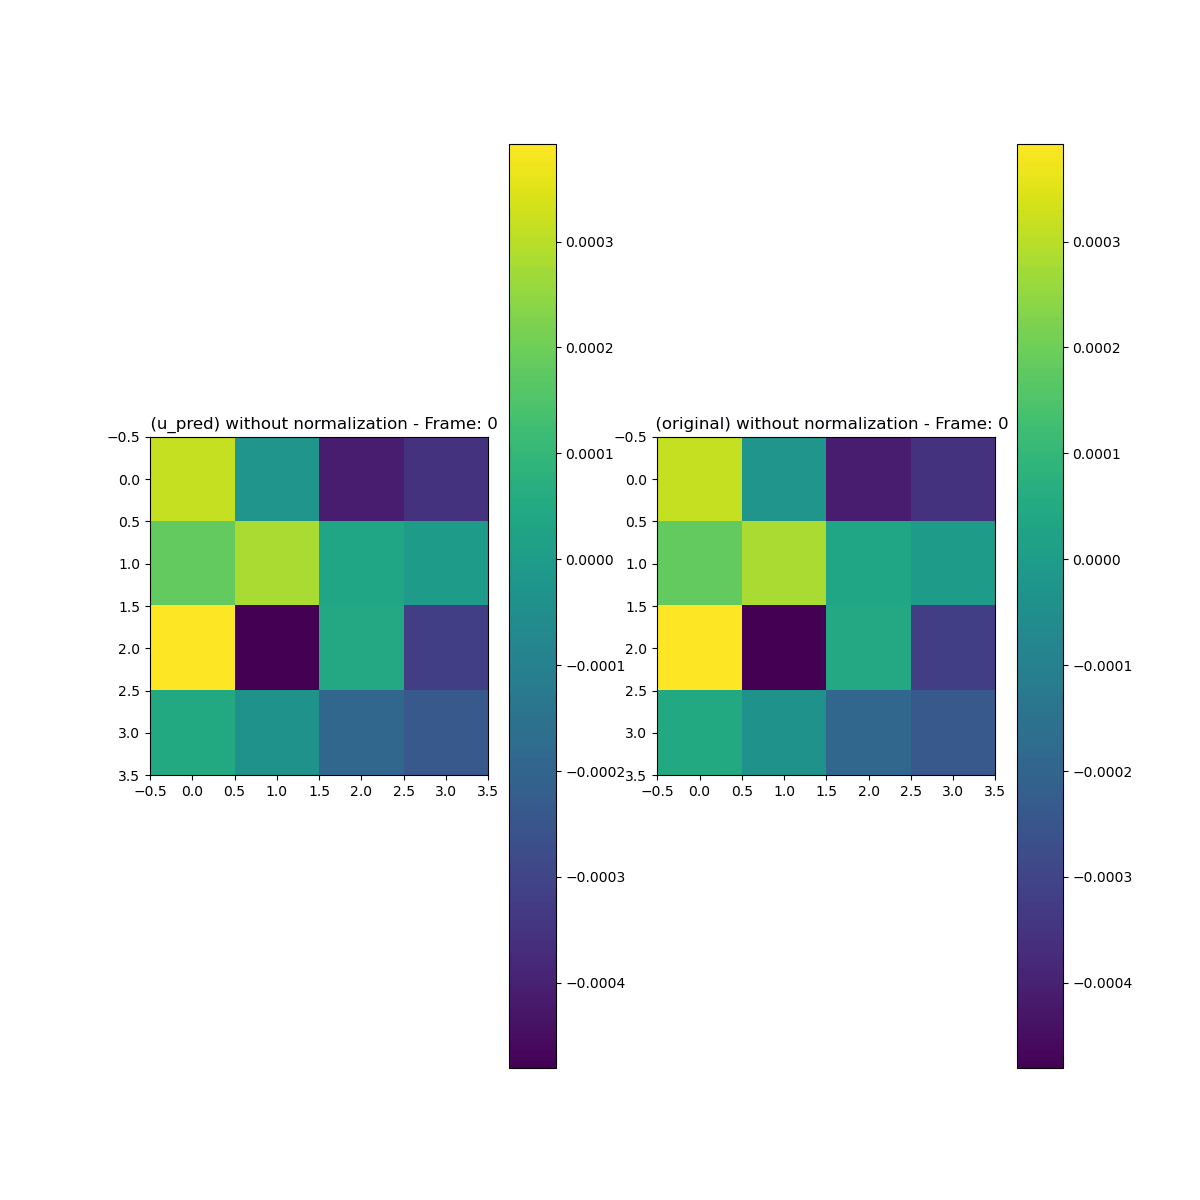

In [ ]:
path="combo_test"
create_gifs(
    memory_rate=parameters.mem_rat,
    u_pred=parameters.A_original,
    original=parameters.A_original,
    save=True,
    path_for_gif=path+".gif",
    duration=500,
    title=" "
)
Image(filename=path+".gif")

In [ ]:
gif = imageio.mimread(path+".gif", memtest=False)
nums = len(gif)
print("Total {} frames in the gif {}!".format(nums, path+".gif"))

Total 100 frames in the gif combo_test.gif!


In [ ]:
# Convert form BGR to RGB
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in gif]

# Save frames to video
out = cv2.VideoWriter(path+'.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 2, (imgs[0].shape[1], imgs[0].shape[0]))

for img in imgs:
    out.write(img)

out.release()